### Arvida Predict 

In [1]:
# !pip uninstall -y jax jaxlib lightweight_mmm numpyro matplotlib

# # Install lightweight_mmm first (as it specifies its dependencies)
# !pip install --upgrade git+https://github.com/google/lightweight_mmm.git

# # Install specific matplotlib version that lightweight_mmm requires
# !pip install matplotlib==3.6.1

# Install other dependencies
# !pip install pandas --upgrade
# !pip install "jax[cpu]"
# !pip install numpyro
#!pip install plotly.express

In [2]:
#!pip install numpyro[cpu] --upgrade
# !pip install pandas openpyxl xlrd
#Install the google-cloud-storage package
# !pip install google-cloud-storage
#pip install icecream
#!pip install gcsfs

##### Import libraries and set environment variables

In [3]:
# Import libraries required. 
import jax.numpy as jnp
import numpyro
import pandas as pd
import matplotlib.pyplot as plt

c:\Users\DavidAirehrourTogeth\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Import the relevant modules of the library
from lightweight_mmm import lightweight_mmm
from lightweight_mmm import optimize_media
from lightweight_mmm import plot
from lightweight_mmm import preprocessing
from lightweight_mmm import utils

In [5]:
# Import required libraries
from google.cloud import storage
import pandas as pd
from io import BytesIO
import os

In [6]:
## Define constants
# Set the path to your service account key JSON file
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'G:/My Drive/together_projects/config/arvida-main-d08dcf823a3e.json'

# Initialize GCS client
storage_client = storage.Client(project='arvida-main')

# Set date range
start_date = '2023-08-01'
end_date = '2024-10-31'

# Define target variable
#target_variable = "application volume"
#target_variable = "total leads"
target_variable = "total leads"

# define target variable title 
target_variable_title = "All Leads"


# # define forecast period
# forecast_period = 12

##### Read Data Section [from GCS]

##### Get external or control variables

In [7]:
# Get competitor data
bucket = storage_client.get_bucket('arvida-mmm')
blob = bucket.blob('external/competitor-data/ad-intel-24-nov-2024.xlsx')

# Download blob content to a pandas DataFrame
data = blob.download_as_bytes()
ad_intel_df = pd.read_excel(BytesIO(data), engine='openpyxl')
ad_intel_df.head()

,Brand,Category,Sub Category,Date,Channel,Product,Spend,Ad Count,Spot Count,Impressions,Advertiser Offline
0,Arvida Group Ltd,"Homes, Properties",Retirement Homes,2022-04-01,Cinema,Arvida Good Friends,14575.0,NaN,279.0,NaN,Arvida Good Friends
1,Arvida Group Ltd,"Homes, Properties",Retirement Homes,2022-04-01,General Display,Arvida Group,1.0,1.0,1.0,113.0,Arvida Group
2,Arvida Group Ltd,"Homes, Properties",Retirement Homes,2022-04-01,Out Of Home,Arvida Group,34286.0,NaN,60.0,NaN,Arvida Group
3,Arvida Group Ltd,"Homes, Properties",Retirement Homes,2022-04-01,Radio,Arvida Group,65865.0,NaN,1567.0,NaN,Arvida Group
4,Arvida Group Ltd,"Homes, Properties",Retirement Homes,2022-04-01,Social,Arvida Group,951.0,2.0,10.0,211534.0,Arvida Group


In [8]:
## Read Seasonality data
# Get seasonality data from GCS
blob = bucket.blob('external/seasonality/arvida-seasonality-data.csv')
data = blob.download_as_bytes()
seasonality_df = pd.read_csv(BytesIO(data))
seasonality_df.head

<bound method NDFrame.head of          date  week  year  month  seasonality_index
0    2-Jan-23     1  2023      1          32.252510
1    9-Jan-23     2  2023      1          32.252510
2   16-Jan-23     3  2023      1          32.252510
3   23-Jan-23     4  2023      1          32.252510
4   30-Jan-23     5  2023      1          32.252510
..        ...   ...   ...    ...                ...
91  30-Sep-24    39  2024      9           7.333881
92   7-Oct-24    40  2024     10         -20.562500
93  14-Oct-24    41  2024     10         -20.562500
94  21-Oct-24    42  2024     10         -20.562500
95  28-Oct-24    43  2024     10         -20.562500

[96 rows x 5 columns]>

In [9]:
## External data sources
# Get Consumer confidence index data and CGPI data
blob = bucket.blob('external/consumer_confidence/anz-roymorgan-cci.csv')
data = blob.download_as_bytes()
cci = pd.read_csv(BytesIO(data))
cci.head()

blob = bucket.blob('external/capital_goods_price_index/cgpi_2022_2024.csv')
data = blob.download_as_bytes()
cgpi = pd.read_csv(BytesIO(data))



##### Get media data

In [10]:
### Get all media data
# Get online media data 
blob = bucket.blob('media/Arvida MMM Data Media Spend By Channels-v3.xlsx')  
data = blob.download_as_bytes()
online_media_df = pd.read_excel(BytesIO(data), engine='openpyxl')
online_media_df

,Start Of Week,Display,Native,Paid Search,Performance Max,Social,Video,Press,Radio,Outdoor,TV,Cinema
0,2023-01-02,452.277142,0.000000,2140.240000,0.0,4167.83,0.000000,1932.340,0.0000,0.0000,0.0000,0.00
1,2023-01-09,632.965026,0.000000,2252.740000,0.0,6684.35,0.000000,14817.830,3500.0000,0.0000,0.0000,0.00
2,2023-01-16,566.625194,0.000000,2237.370000,0.0,7897.02,0.000000,8638.950,2500.0000,0.0000,55436.9616,0.00
3,2023-01-23,578.202123,0.000000,2366.940000,0.0,6821.79,0.000000,4726.450,1668.4250,0.0000,0.0000,0.00
4,2023-01-30,455.488126,0.000000,3618.370000,0.0,4649.75,0.000000,1624.000,0.0000,0.0000,30003.4584,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
91,2024-09-30,1015.742809,855.661851,5143.950000,0.0,8813.60,1604.954391,7438.200,17929.0933,6244.0879,0.0000,5048.25
92,2024-10-07,1783.173010,751.496335,4756.962842,0.0,11805.01,1775.233707,15448.200,490.0000,5994.9379,88499.1269,5048.25
93,2024-10-14,1717.634584,561.210000,5655.910000,0.0,10647.71,1747.960615,12897.040,490.0000,5994.9379,11454.5455,5048.25
94,2024-10-21,1159.280147,1205.380800,5009.560000,0.0,9109.28,1751.421527,35533.544,36127.0000,9049.9379,39657.7955,5048.25


##### Get client outcome variables

In [11]:
## Leads data 
# Get Leads data 
blob = bucket.blob('client-data/Final Total Leads.xlsx')  
data = blob.download_as_bytes()
leads_application_df = pd.read_excel(BytesIO(data), engine='openpyxl')
leads_application_df.columns = leads_application_df.columns.str.lower()
leads_application_df.head()

## Leads data 
# # Get Leads data 
# blob = bucket.blob('client-data/Final MMM Qualified Leads-v3.xlsx')  
# data = blob.download_as_bytes()
# leads_application_df = pd.read_excel(BytesIO(data), engine='openpyxl')
# leads_application_df.columns = leads_application_df.columns.str.lower()
# leads_application_df.head()

,start of week,total leads,lead value
0,2023-01-02,113,5.318165e+06
1,2023-01-09,137,6.447686e+06
2,2023-01-16,112,5.271101e+06
3,2023-01-23,111,5.224038e+06
4,2023-01-30,139,6.541813e+06


### Data Preparation Section


##### External/control variables

In [12]:
## ad intel
# Drop unneeded columns  
ad_intel_df_cleaned = ad_intel_df.drop(['Category','Sub Category', 
                                        'Product', 'Ad Count', 'Spot Count', 
                                        'Impressions','Advertiser Offline'], axis=1)
# Group by channel and date to see spend by channel
ad_intel_df_cleaned = ad_intel_df.groupby(['Brand', 'Channel', 'Date'])['Spend'].sum().reset_index()
ad_intel_df_cleaned.columns = ad_intel_df_cleaned.columns.str.lower()
ad_intel_df_cleaned.head()


,brand,channel,date,spend
0,Arvida Group Ltd,Cinema,2022-03-01,13278.0
1,Arvida Group Ltd,Cinema,2022-04-01,14575.0
2,Arvida Group Ltd,Cinema,2022-05-01,16334.0
3,Arvida Group Ltd,Cinema,2024-07-01,44593.0
4,Arvida Group Ltd,Cinema,2024-08-01,44860.0


In [13]:
# Process ad_intel data to calculate weekly share of spend across different brands:
# 1. Expands monthly data into weekly data by evenly distributing spend across 4 weeks per month
# 2. Calculates share of spend for each brand by dividing their spend by total spend in that channel/month
# 3. Creates a pivot table showing share of spend by brand over time
# 4. Normalizes the data so shares sum to 1 for each time period
# 5. Filters for the date range of interest and drops unnecessary columns

import calendar

def expand_to_weekly(row):
    # Get the month and year from the original date
    date = row['date']
    month = date.month
    year = date.year
    
    # Calculate the number of days in the month using calendar module
    days_in_month = calendar.monthrange(year, month)[1]
    
    # Create 4 evenly spaced weekly dates within the month
    weekly_dates = [
        pd.Timestamp(year, month, 1) + pd.Timedelta(days=int(i * (days_in_month / 4))) 
        for i in range(4)
    ]
    
    return weekly_dates

# Alternative expansion method
def expand_dataframe_to_weekly(df):
    # Create a new dataframe to store expanded rows
    expanded_rows = []
    
    # Iterate through each row in the original dataframe
    for _, row in df.iterrows():
        # Generate weekly dates
        weekly_dates = expand_to_weekly(row)
        
        # Create a copy of the row for each week
        for date in weekly_dates:
            new_row = row.copy()
            new_row['date'] = date
            expanded_rows.append(new_row)
    
    # Convert to DataFrame
    return pd.DataFrame(expanded_rows)

# Use the expansion function
ad_intel_df_expanded = expand_dataframe_to_weekly(ad_intel_df_cleaned)

# Ensure date is in datetime format
ad_intel_df_expanded['date'] = pd.to_datetime(ad_intel_df_expanded['date'])

# Redistribute spend evenly across weeks
columns_to_distribute = ['spend']
for col in columns_to_distribute:
    ad_intel_df_expanded[col] = ad_intel_df_expanded[col] / 4

# Create a 'Month' column for grouping by month
ad_intel_df_expanded['Month'] = ad_intel_df_expanded['date'].dt.to_period('M').astype(str)

# Calculate total spend for each Channel and Month (monthly total for each channel)
ad_intel_df_expanded['total_spend_channel_month'] = ad_intel_df_expanded.groupby(['channel', 'Month'])['spend'].transform('sum')

# Calculate share of spend at the weekly level using the monthly totals
ad_intel_df_expanded['share_of_spend'] = ad_intel_df_expanded['spend'] / ad_intel_df_expanded['total_spend_channel_month']

# Filter for date range and drop specified columns
competitor_filtered_df = ad_intel_df_expanded[
    (ad_intel_df_expanded['date'] >= start_date) & 
    (ad_intel_df_expanded['date'] <= end_date)
][['brand', 'channel', 'date', 'share_of_spend']]

# Pivot the Share_of_Spend by Brand for each Channel and Date
competitor_filtered_df = competitor_filtered_df.pivot_table(
    index=['date'],  # Group by Date
    columns='brand',           # Pivot on Brand
    values='share_of_spend',   # Use Share_of_Spend as the values
    aggfunc='sum'              # Aggregate function (sum is appropriate here)
).reset_index()

# Reset column names for easier access
competitor_filtered_df.columns.name = None  # Remove the name of columns for clarity

# Normalize the dataset so each row sums to 1
competitor_filtered_df.iloc[:, 1:] = competitor_filtered_df.iloc[:, 1:].div(competitor_filtered_df.iloc[:, 1:].sum(axis=1), axis=0)
competitor_filtered_df.head()


,date,Arvida Group Ltd,Bupa NZ (prev Guardian Health),Metlifecare Group,Oceania Group,Ryman Healthcare Ltd,Summerset Group Holdings Ltd,Vivid Living Ltd
0,2023-08-01,0.047612,0.115666,0.097942,0.270284,0.308859,0.156818,0.002820
1,2023-08-08,0.047612,0.115666,0.097942,0.270284,0.308859,0.156818,0.002820
2,2023-08-16,0.047612,0.115666,0.097942,0.270284,0.308859,0.156818,0.002820
3,2023-08-24,0.047612,0.115666,0.097942,0.270284,0.308859,0.156818,0.002820
4,2023-09-01,0.055028,0.111643,0.052096,0.320674,0.274407,0.184595,0.001557


In [14]:
# make columns lower case
competitor_filtered_df.columns = competitor_filtered_df.columns.str.lower()

# Remove Arvida Group Ltd from the pivot table and fill NaN values with 0
competitor_filtered_df = competitor_filtered_df.drop('arvida group ltd', axis=1).fillna(0)

# Sum all numeric columns (excluding Channel and Date) to get total competitor share of spend
competitor_filtered_df['compete_sos'] = competitor_filtered_df.select_dtypes(include=['float64', 'int64']).sum(axis=1)
# Keep only Date and compete_sos columns
competitor_filtered_df = competitor_filtered_df[['date', 'compete_sos']]
competitor_filtered_df.head(3)

,date,compete_sos
0,2023-08-01,0.952388
1,2023-08-08,0.952388
2,2023-08-16,0.952388


In [15]:
## seasonality_df
# Convert date column to datetime if not already and select date range
seasonality_df['date'] = pd.to_datetime(seasonality_df['date'], format='%d-%b-%y')

seasonality_df = seasonality_df[
    (seasonality_df['date'] >= pd.to_datetime(start_date)) & 
    (seasonality_df['date'] <= pd.to_datetime(end_date))
][['date', 'seasonality_index']]
seasonality_df

,date,seasonality_index
31,2023-08-07,-9.199160
32,2023-08-14,-9.199160
33,2023-08-21,-9.199160
34,2023-08-28,-9.199160
35,2023-09-04,7.333881
...,...,...
91,2024-09-30,7.333881
92,2024-10-07,-20.562500
93,2024-10-14,-20.562500
94,2024-10-21,-20.562500


In [16]:
## data prep cci and cgpi
# Convert date to datetime and filter for date range period
cci['date'] = pd.to_datetime(cci['date'], format='%d-%b-%y')
# Filter for date range
cci = cci[(cci['date'] >= start_date) & (cci['date'] <= end_date)]
cci = cci[['date', 'cci']]
cci

# Convert date to datetime
cgpi['date'] = pd.to_datetime(cgpi['date'], format='%d-%b-%y')
# Filter for date range
cgpi = cgpi[(cgpi['date'] >= start_date) & (cgpi['date'] <= end_date)]
cgpi = cgpi[['date', 'cgpi']]
cgpi


,date,cgpi
83,2023-08-07,1056.0
84,2023-08-14,1056.0
85,2023-08-21,1056.0
86,2023-08-28,1056.0
87,2023-09-04,1056.0
...,...,...
143,2024-09-30,1087.0
144,2024-10-07,1087.0
145,2024-10-14,1087.0
146,2024-10-21,1087.0


##### Online and offline media data prep

In [17]:
##### Online and offline media where combined in the dataset

online_media_df.head()

,Start Of Week,Display,Native,Paid Search,Performance Max,Social,Video,Press,Radio,Outdoor,TV,Cinema
0,2023-01-02,452.277142,0.0,2140.24,0.0,4167.83,0.0,1932.34,0.000,0.0,0.0000,0.0
1,2023-01-09,632.965026,0.0,2252.74,0.0,6684.35,0.0,14817.83,3500.000,0.0,0.0000,0.0
2,2023-01-16,566.625194,0.0,2237.37,0.0,7897.02,0.0,8638.95,2500.000,0.0,55436.9616,0.0
3,2023-01-23,578.202123,0.0,2366.94,0.0,6821.79,0.0,4726.45,1668.425,0.0,0.0000,0.0
4,2023-01-30,455.488126,0.0,3618.37,0.0,4649.75,0.0,1624.00,0.000,0.0,30003.4584,0.0


In [18]:
## media with all detailed features 
# Ensure all column names are lowercase
online_media_df.columns = online_media_df.columns.str.lower()

# # Flatten the multi-index columns (if needed)
online_media_df.columns.name = None  # Remove pivot table column grouping
online_media_df.columns = [str(col) for col in online_media_df.columns]
online_media_df.columns = online_media_df.columns.str.lower()

# Rename 'start of week' to 'week'
online_media_pivot_df = online_media_df.rename(columns={'start of week': 'week'})

import numpy as np
# Replace 50% of zeros with 1, keep other zeros as 0 tokeep the model stable
mask = (online_media_pivot_df == 0)
random_mask = np.random.random(size=mask.shape) < 0.5
online_media_pivot_df = online_media_pivot_df.mask(mask & random_mask, 1)
# Replace remaining NaN with 1
online_media_pivot_df = online_media_pivot_df.fillna(1)
##

##
# Convert date to datetime
online_media_pivot_df['week'] = pd.to_datetime(online_media_pivot_df['week'], format='%d-%b-%y')
# Filter for date range
online_media_pivot_df = online_media_pivot_df[(online_media_pivot_df['week'] >= start_date) & (online_media_pivot_df['week'] <= end_date)]

# Display the resulting dataframe
online_media_pivot_df.head()

,week,display,native,paid search,performance max,social,video,press,radio,outdoor,tv,cinema
31,2023-08-07,804.583423,1.0,3373.80,323.412125,3626.17,1278.484853,15946.4833,8909.0,6901.7264,1.000,0.0
32,2023-08-14,711.824695,0.0,3763.72,369.465759,3344.33,6991.692392,13593.4200,8909.0,9856.9432,37972.535,1.0
33,2023-08-21,717.270819,0.0,3576.46,330.441422,11089.26,1439.057783,14337.0433,8909.0,2089.6532,0.000,1.0
34,2023-08-28,1333.309844,0.0,5173.20,217.695633,7249.71,6326.310633,6179.6400,8909.0,11283.2394,30341.320,0.0
35,2023-09-04,1968.765903,0.0,6161.08,156.295875,5042.09,790.318573,11948.3500,8909.0,11291.3711,48249.000,0.0


Outcome variable/s data prep

In [19]:
## leads_application_df
# Convert date to datetime
leads_application_df['start of week'] = pd.to_datetime(leads_application_df['start of week'], format='%d-%b-%y')
# Filter for date range
leads_application_df = leads_application_df[(leads_application_df['start of week'] >= start_date) & (leads_application_df['start of week'] <= end_date)]
leads_application_df


## Applications Data 
# Convert date to datetime
# applications_df ['start of week'] = pd.to_datetime(applications_df['start of week'], format='%d-%b-%y')
# # Filter for date range
# applications_df = applications_df[(applications_df['start of week'] >= start_date) & (applications_df['start of week'] <= end_date)]
# applications_df


,start of week,total leads,lead value
31,2023-08-07,151,7.106574e+06
32,2023-08-14,159,7.483081e+06
33,2023-08-21,175,8.236096e+06
34,2023-08-28,143,6.730067e+06
35,2023-09-04,134,6.306496e+06
...,...,...,...
91,2024-09-30,204,9.600934e+06
92,2024-10-07,192,9.036173e+06
93,2024-10-14,233,1.096577e+07
94,2024-10-21,194,9.130300e+06


In [20]:
# Prepend "mdsp_" to online media channel columns if not already prefixed
online_media_pivot_df.columns = ['mdsp_' + col if col not in ['week'] and not col.startswith('mdsp_')
                                 else col for col in online_media_pivot_df.columns]
online_media_pivot_df.head()

,week,mdsp_display,mdsp_native,mdsp_paid search,mdsp_performance max,mdsp_social,mdsp_video,mdsp_press,mdsp_radio,mdsp_outdoor,mdsp_tv,mdsp_cinema
31,2023-08-07,804.583423,1.0,3373.80,323.412125,3626.17,1278.484853,15946.4833,8909.0,6901.7264,1.000,0.0
32,2023-08-14,711.824695,0.0,3763.72,369.465759,3344.33,6991.692392,13593.4200,8909.0,9856.9432,37972.535,1.0
33,2023-08-21,717.270819,0.0,3576.46,330.441422,11089.26,1439.057783,14337.0433,8909.0,2089.6532,0.000,1.0
34,2023-08-28,1333.309844,0.0,5173.20,217.695633,7249.71,6326.310633,6179.6400,8909.0,11283.2394,30341.320,0.0
35,2023-09-04,1968.765903,0.0,6161.08,156.295875,5042.09,790.318573,11948.3500,8909.0,11291.3711,48249.000,0.0


In [21]:
leads_application_df.head()

,start of week,total leads,lead value
31,2023-08-07,151,7.106574e+06
32,2023-08-14,159,7.483081e+06
33,2023-08-21,175,8.236096e+06
34,2023-08-28,143,6.730067e+06
35,2023-09-04,134,6.306496e+06


In [22]:
## Merge all dataset intoone dataframe
import pandas as pd

# Ensure all date columns are in datetime format
#applications_df ['start of week'] = pd.to_datetime(applications_df ['start of week'])

leads_application_df['start of week'] = pd.to_datetime(leads_application_df['start of week'])
online_media_pivot_df['week'] = pd.to_datetime(online_media_pivot_df['week'])
competitor_filtered_df['date'] = pd.to_datetime(competitor_filtered_df['date'])
seasonality_df['date'] = pd.to_datetime(seasonality_df['date'])
cgpi['date'] = pd.to_datetime(cgpi['date'])
cci['date'] = pd.to_datetime(cci['date'])


In [23]:
# Rename 'date' columns to prevent conflicts during merge
competitor_filtered_df = competitor_filtered_df.rename(columns={'date': 'competitor_date'})
seasonality_df = seasonality_df.rename(columns={'date': 'seasonality_date'})
cgpi = cgpi.rename(columns={'date': 'cgpi_date'})
cci = cci.rename(columns={'date': 'cci_date'})

# Align all dataframes by merging on the appropriate columns
merged_df = (
    leads_application_df
    .merge(online_media_pivot_df, left_on='start of week', right_on='week', how='left')
    .merge(competitor_filtered_df, left_on='start of week', right_on='competitor_date', how='left')
    .merge(seasonality_df, left_on='start of week', right_on='seasonality_date', how='left')
    .merge(cgpi, left_on='start of week', right_on='cgpi_date', how='left')
    .merge(cci, left_on='start of week', right_on='cci_date', how='left')
 )

# Drop redundant columns after merging (e.g., extra 'week' and renamed date columns)
merged_df = merged_df.drop(columns=['week', 'competitor_date', 'seasonality_date', 'cgpi_date', 'cci_date'], errors='ignore')

# Ensure the dataframe is sorted by 'start of week'
merged_df = merged_df.sort_values(by='start of week').reset_index(drop=True)



# Forward fill NaN values in compete_sos column with the latest available value
merged_df['compete_sos'] = merged_df['compete_sos'].fillna(method='ffill')
# 2. Then try backward fill for any remaining NaNs at the start
merged_df['compete_sos'] = merged_df['compete_sos'].fillna(method='bfill')

# 3. If there are still any NaNs, fill with the mean
merged_df['compete_sos'] = merged_df['compete_sos'].fillna(merged_df['compete_sos'].mean())

# Convert compete_sos to percentage by multiplying by 100
merged_df['compete_sos'] = merged_df['compete_sos'] * 100

# Display the final merged dataframe
merged_df.head()


C:\Users\DavidAirehrourTogeth\AppData\Local\Temp\ipykernel_54652\3989192294.py:26: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df['compete_sos'] = merged_df['compete_sos'].fillna(method='ffill')
C:\Users\DavidAirehrourTogeth\AppData\Local\Temp\ipykernel_54652\3989192294.py:28: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df['compete_sos'] = merged_df['compete_sos'].fillna(method='bfill')


,start of week,total leads,lead value,mdsp_display,mdsp_native,mdsp_paid search,mdsp_performance max,mdsp_social,mdsp_video,mdsp_press,mdsp_radio,mdsp_outdoor,mdsp_tv,mdsp_cinema,compete_sos,seasonality_index,cgpi,cci
0,2023-08-07,151,7.106574e+06,804.583423,1.0,3373.80,323.412125,3626.17,1278.484853,15946.4833,8909.0,6901.7264,1.000,0.0,94.088631,-9.199160,1056.0,85.0
1,2023-08-14,159,7.483081e+06,711.824695,0.0,3763.72,369.465759,3344.33,6991.692392,13593.4200,8909.0,9856.9432,37972.535,1.0,94.088631,-9.199160,1056.0,85.0
2,2023-08-21,175,8.236096e+06,717.270819,0.0,3576.46,330.441422,11089.26,1439.057783,14337.0433,8909.0,2089.6532,0.000,1.0,94.088631,-9.199160,1056.0,85.0
3,2023-08-28,143,6.730067e+06,1333.309844,0.0,5173.20,217.695633,7249.71,6326.310633,6179.6400,8909.0,11283.2394,30341.320,0.0,94.088631,-9.199160,1056.0,85.0
4,2023-09-04,134,6.306496e+06,1968.765903,0.0,6161.08,156.295875,5042.09,790.318573,11948.3500,8909.0,11291.3711,48249.000,0.0,94.088631,7.333881,1056.0,86.4


#### Make a switch for demo purposes

In [24]:
# For the purpose of demonstration I will be using the redistributed dataset for the modelling
merged_df_demo = pd.read_csv("merged_df_demo.csv")
merged_df = merged_df_demo

In [25]:
merged_df_demo.head()

,total leads,start of week,mdsp_display,mdsp_native,mdsp_paid search,mdsp_performance max,mdsp_social,mdsp_video,mdsp_cinema,mdsp_outdoor,mdsp_press,mdsp_radio,mdsp_tv,compete_sos,seasonality_index,cgpi,cci
0,151,7/08/2023,1113.769779,232.139652,3509.755913,307.013774,5526.906381,84.593542,0.000000,4010.784456,3707.610399,7108.569709,4282.680068,94.088631,-9.199160,1056,85.0
1,159,14/08/2023,0.000000,492.929539,3204.885394,416.533942,7303.548543,2716.033613,192.041936,403.063389,7291.585427,5875.014660,0.000000,94.088631,-9.199160,1056,85.0
2,175,21/08/2023,304.302732,662.028941,4693.891520,180.177849,7775.441868,782.480336,439.860510,3380.428102,21147.864070,6546.825534,2589.668967,94.088631,-9.199160,1056,85.0
3,143,28/08/2023,201.082113,432.201355,2967.137707,167.095537,4718.285585,45.682115,495.639101,0.000000,912.842844,2478.457693,0.000000,94.088631,-9.199160,1056,85.0
4,134,4/09/2023,995.636047,26.006554,3096.797502,64.159604,3094.617417,0.000000,0.000000,2643.747850,1475.356896,2551.658791,0.000000,94.088631,7.333881,1056,86.4


#### Perform 3 stages of checks before modelling


In [26]:
## Data Quality Check: Null Values, Infinite Values, and DataFrame Shape
# Import numpy
import numpy as np

# Check for any null values in the dataframe
print("\nNumber of null values in each column:")
print(merged_df.isnull().sum())

print("\nTotal number of null values in entire dataframe:", merged_df.isnull().sum().sum())

# Check if there are any infinite values
print("\nNumber of infinite values in each column:")
print(np.isinf(merged_df.select_dtypes(include=np.number)).sum())

print("\nDataframe shape:", merged_df.shape)


Number of null values in each column:
total leads             0
start of week           0
mdsp_display            0
mdsp_native             0
mdsp_paid search        0
mdsp_performance max    0
mdsp_social             0
mdsp_video              0
mdsp_cinema             0
mdsp_outdoor            0
mdsp_press              0
mdsp_radio              0
mdsp_tv                 0
compete_sos             0
seasonality_index       0
cgpi                    0
cci                     0
dtype: int64

Total number of null values in entire dataframe: 0

Number of infinite values in each column:
total leads             0
mdsp_display            0
mdsp_native             0
mdsp_paid search        0
mdsp_performance max    0
mdsp_social             0
mdsp_video              0
mdsp_cinema             0
mdsp_outdoor            0
mdsp_press              0
mdsp_radio              0
mdsp_tv                 0
compete_sos             0
seasonality_index       0
cgpi                    0
cci                  

In [27]:
# The Variance Inflation Factor (VIF) is a measure used to detect the presence and 
# severity of multicollinearity in a set of predictor variables in a regression model. 
# Multicollinearity occurs when two or more predictor variables in a model are highly correlated, 
# meaning that one can be predicted from the others with a substantial degree of accuracy. 
# In such cases, the coefficients of the regression model may be unreliable.

# Some insights to what our VIF values mean:
# VIF = 1: No correlation between the predictor and the remaining predictor variables.
# 1 < VIF <= 7: Moderately correlated. This is the standard acceptable range.
# VIF > 7: High correlation. This indicates that the predictor variables are highly correlated 
# with each other, which can weaken the statistical power of our regression model.

# Check for Multicollinearity among the media channels
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Drop datetime and object columns
X = online_media_pivot_df.drop(columns=["week" ]) # Predictor variables are now the filtered media channels
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data.sort_values(by='VIF', ascending=False))

# Calculate and print the correlation matrix
correlation_matrix = X.corr()
print('\n')
print(correlation_matrix)

                 feature        VIF
2       mdsp_paid search  17.830697
4            mdsp_social   7.236970
8           mdsp_outdoor   6.926193
3   mdsp_performance max   3.960172
1            mdsp_native   3.828474
10           mdsp_cinema   3.771761
0           mdsp_display   3.716532
6             mdsp_press   3.193201
5             mdsp_video   3.001285
7             mdsp_radio   2.736574
9                mdsp_tv   2.577960


                      mdsp_display  mdsp_native  mdsp_paid search  \
mdsp_display              1.000000    -0.183426          0.237569   
mdsp_native              -0.183426     1.000000         -0.026602   
mdsp_paid search          0.237569    -0.026602          1.000000   
mdsp_performance max     -0.017278    -0.075603         -0.183723   
mdsp_social               0.169625    -0.028622          0.131322   
mdsp_video                0.316105    -0.483041          0.176151   
mdsp_press                0.286014     0.029789          0.303183   
mdsp_radio    

In [28]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
# from statsmodels.stats.stattools import durbin_watson
# from statsmodels.stats.diagnostic import het_breuschpagan
# from statsmodels.stats.stattools import jarque_bera
#from statsmodels.stats.outliers_influence import variance_inflation_factor
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import train_test_split


# Perform OLS regression to analyze media channel effectiveness:
# We want to check if the coefficients (impact) of different media channels are reasonable
# or if they show signs of multicollinearity/skewness that could affect our interpretation
# This helps validate if our media mix model assumptions are sound

# Get media columns (those starting with 'mdsp_')
media_columns = [col for col in merged_df.columns if col.startswith('mdsp_')]

# Assign X (features) and y (target)
X = merged_df[media_columns]
y = merged_df['total leads']


X = sm.add_constant(X)
y = merged_df['total leads']
result = sm.OLS(y, X).fit()
# Print summary to examine coefficients, significance, and model fit
print(result.summary())


# Get the coefficients from the regression results
coefficients = result.params

# Find negative coefficients and their p-values
negative_coefs = coefficients[coefficients < 0]
p_values = result.pvalues[coefficients < 0]

if len(negative_coefs) > 0:
    # Check if there's only one negative coefficient and it's not statistically significant
    if len(negative_coefs) == 1 and p_values[0] > 0.05:
        print("\nOne negative coefficient detected but it is not statistically significant.")
        print("It is okay to proceed with modelling.")
    else:
        print("\nWarning: Negative coefficients detected!")
        print("\nThe following media channels show negative impact on leads:")
        for coef, p_val in zip(negative_coefs.index, p_values):
            print(f"\n{coef}:")
            print(f"Coefficient: {negative_coefs[coef]:.4f}")
            print(f"P-value: {p_val:.4f}")
            #if p_val <= 0.05:
        #print("This negative effect is statistically significant and should be investigated.")
        print("\nConsider:")
        print("1. Checking for multicollinearity with other media channels")
        print("2. Reviewing data quality and measurement")
        print("3. Examining potential confounding variables")
else:
    print("\nNo negative coefficients detected - all media channels show positive impact on leads.")



                            OLS Regression Results                            
Dep. Variable:            total leads   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     129.7
Date:                Tue, 28 Jan 2025   Prob (F-statistic):           3.12e-34
Time:                        19:18:51   Log-Likelihood:                -231.42
No. Observations:                  65   AIC:                             486.8
Df Residuals:                      53   BIC:                             512.9
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   71.2507 

C:\Users\DavidAirehrourTogeth\AppData\Local\Temp\ipykernel_54652\1648026694.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(negative_coefs) == 1 and p_values[0] > 0.05:


In [29]:
merged_df.head()

,total leads,start of week,mdsp_display,mdsp_native,mdsp_paid search,mdsp_performance max,mdsp_social,mdsp_video,mdsp_cinema,mdsp_outdoor,mdsp_press,mdsp_radio,mdsp_tv,compete_sos,seasonality_index,cgpi,cci
0,151,7/08/2023,1113.769779,232.139652,3509.755913,307.013774,5526.906381,84.593542,0.000000,4010.784456,3707.610399,7108.569709,4282.680068,94.088631,-9.199160,1056,85.0
1,159,14/08/2023,0.000000,492.929539,3204.885394,416.533942,7303.548543,2716.033613,192.041936,403.063389,7291.585427,5875.014660,0.000000,94.088631,-9.199160,1056,85.0
2,175,21/08/2023,304.302732,662.028941,4693.891520,180.177849,7775.441868,782.480336,439.860510,3380.428102,21147.864070,6546.825534,2589.668967,94.088631,-9.199160,1056,85.0
3,143,28/08/2023,201.082113,432.201355,2967.137707,167.095537,4718.285585,45.682115,495.639101,0.000000,912.842844,2478.457693,0.000000,94.088631,-9.199160,1056,85.0
4,134,4/09/2023,995.636047,26.006554,3096.797502,64.159604,3094.617417,0.000000,0.000000,2643.747850,1475.356896,2551.658791,0.000000,94.088631,7.333881,1056,86.4


#### Google Bayesian Modelling using Google Lightweight MMM ### 

In [30]:
# Get all media spend columns (those starting with 'mdsp_')
media_cols = [col for col in merged_df.columns if col.startswith('mdsp_')]

# Extract media data as numpy array, replacing NaN with 0
media_data = merged_df[media_cols].fillna(0).to_numpy()

# Extract target variables
target = merged_df[target_variable].to_numpy()

# Calculate total spend for each media channel
costs = merged_df[media_cols].fillna(0).sum().to_numpy()

# Get control variable columns and handle any NaN values
control_cols = [col for col in merged_df.columns 
               if not col.startswith('mdsp_') 
               and 'week' not in col.lower()
               and col not in leads_application_df.columns]

# Extract control data as numpy array, replacing NaN values with 0
control_data = merged_df[control_cols].fillna(0).to_numpy()

In [31]:
# Get the data size
data_size = media_data.shape[0]
data_size

# Split and scale data and set seed value.
#split_point at at 70/30 or 80/20 ratio
split_point = int(data_size * 0.8)  # 80% for training

# Media data
media_data_train = media_data[:split_point, ...]
media_data_test = media_data[split_point:, ...]

# Extra features
extra_features_train = control_data[:split_point, ...]
extra_features_test = control_data[split_point:, ...]
# Target
target_train = target[:split_point]

# Target
target_train = target[:split_point].reshape(-1)

In [32]:
# # Get summary statistics of media_data_train array
# print("Summary statistics of media_data_train:")
# print(f"Shape: {media_data_train.shape}")
# print("\nMean values per channel:")
# print(np.mean(media_data_train, axis=0))
# print("\nMedian values per channel:")
# print(np.median(media_data_train, axis=0))
# print("\n75th percentile values per channel:")
# print(np.percentile(media_data_train, 75, axis=0))
# print("\nStandard deviation per channel:")
# print(np.std(media_data_train, axis=0))
# print("\nMin values per channel:")
# print(np.min(media_data_train, axis=0))
# print("\nMax values per channel:")
# print(np.max(media_data_train, axis=0))

In [34]:
# # Plot distribution of media spend across channels
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Create a figure with subplots for each channel
# n_channels = media_data_train.shape[1]
# fig, axes = plt.subplots(4, 3, figsize=(15, 20))
# axes = axes.ravel()

# channel_names = ['Display', 'Native', 'Paid Search', 'Performance Max', 
#                  'Social', 'Video', 'Press', 'Radio', 'Outdoor', 'TV', 'Cinema']

# # Plot histogram for each channel
# for i in range(n_channels):
#     sns.histplot(data=media_data_train[:, i], ax=axes[i], bins=30)
#     axes[i].set_title(f'{channel_names[i]} Distribution')
#     axes[i].set_xlabel('Spend')
#     axes[i].set_ylabel('Count')

# # Remove empty subplot
# if n_channels < 12:
#     fig.delaxes(axes[11])

# plt.tight_layout()
# plt.show()

# # Print summary statistics
# print("\nSummary Statistics:")
# print(f"Shape: {media_data_train.shape}")
# for i, channel in enumerate(channel_names):
#     print(f"\n{channel}:")
#     print(f"Mean: {np.mean(media_data_train[:,i]):.2f}")
#     print(f"Median: {np.median(media_data_train[:,i]):.2f}")
#     print(f"Std Dev: {np.std(media_data_train[:,i]):.2f}")
#     print(f"Min: {np.min(media_data_train[:,i]):.2f}")
#     print(f"Max: {np.max(media_data_train[:,i]):.2f}")

In [35]:
# # Get summary statistics of media_data_train array
# print("Summary statistics of media_data_train:")
# print(f"Shape: {media_data_train.shape}")
# print("\nMean values per channel:")
# print(np.mean(media_data_train, axis=0))
# print("\nMedian values per channel:")
# print(np.median(media_data_train, axis=0))
# print("\n75th percentile values per channel:")
# print(np.percentile(media_data_train, 75, axis=0))
# print("\nStandard deviation per channel:")
# print(np.std(media_data_train, axis=0))
# print("\nMin values per channel:")
# print(np.min(media_data_train, axis=0))
# print("\nMax values per channel:")
# print(np.max(media_data_train, axis=0))

In [36]:
# Initialize custom scalers for different data types
# Each scaler will divide values by their mean during transformation
# media_scaler: For scaling media spend data across channels
# extra_features_scaler: For scaling control variables like seasonality, competition
# target_scaler: For scaling the target variable (leads)
# cost_scaler: For scaling cost data
media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
extra_features_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)


media_data_train = media_scaler.fit_transform(media_data_train)
extra_features_train = extra_features_scaler.fit_transform(extra_features_train)
target_train = target_scaler.fit_transform(target_train)
costs = cost_scaler.fit_transform(costs)

# for any NA train data set as 0
media_data_train = jnp.nan_to_num(media_data_train, 0.0)


In [37]:
correlations, variances, spend_fractions, variance_inflation_factors = preprocessing.check_data_quality(
    media_data=media_scaler.transform(media_data),
    target_data=target_scaler.transform(target),
    cost_data=costs,
    channel_names=media_cols,
    extra_features_data=extra_features_scaler.transform(control_data))

In [38]:
correlations[0].style.background_gradient(cmap='RdBu', vmin=-1, vmax=1).format(precision=3)

,mdsp_display,mdsp_native,mdsp_paid search,mdsp_performance max,mdsp_social,mdsp_video,mdsp_cinema,mdsp_outdoor,mdsp_press,mdsp_radio,mdsp_tv,extra_feature_0,extra_feature_1,extra_feature_2,extra_feature_3,target
mdsp_display,1.000,0.847,0.837,0.849,0.863,0.777,0.888,0.848,0.847,0.825,0.887,-0.327,-0.583,0.440,0.338,0.873
mdsp_native,0.847,1.000,0.890,0.849,0.845,0.786,0.808,0.866,0.849,0.821,0.863,-0.254,-0.549,0.506,0.228,0.900
mdsp_paid search,0.837,0.890,1.000,0.881,0.908,0.809,0.839,0.883,0.881,0.888,0.863,-0.296,-0.533,0.508,0.196,0.955
mdsp_performance max,0.849,0.849,0.881,1.000,0.899,0.820,0.861,0.847,0.858,0.900,0.870,-0.205,-0.568,0.493,0.159,0.916
mdsp_social,0.863,0.845,0.908,0.899,1.000,0.775,0.834,0.862,0.878,0.878,0.855,-0.253,-0.523,0.476,0.162,0.943
mdsp_video,0.777,0.786,0.809,0.820,0.775,1.000,0.816,0.822,0.806,0.847,0.850,-0.217,-0.585,0.469,0.219,0.842
mdsp_cinema,0.888,0.808,0.839,0.861,0.834,0.816,1.000,0.850,0.834,0.884,0.874,-0.388,-0.539,0.476,0.354,0.872
mdsp_outdoor,0.848,0.866,0.883,0.847,0.862,0.822,0.850,1.000,0.842,0.883,0.879,-0.282,-0.577,0.531,0.265,0.909
mdsp_press,0.847,0.849,0.881,0.858,0.878,0.806,0.834,0.842,1.000,0.845,0.872,-0.261,-0.593,0.469,0.209,0.909
mdsp_radio,0.825,0.821,0.888,0.900,0.878,0.847,0.884,0.883,0.845,1.000,0.853,-0.297,-0.560,0.472,0.245,0.911


In [39]:
# # Calculate total spend for each channel
# total_spend = jnp.sum(costs)

# # Calculate fraction for each channel
# spend_fractions_pct = (costs / total_spend) * 100

# # Create DataFrame with channel names and spend fractions
# spend_fractions_df = pd.DataFrame({
#     'Channel': ['Display', 'Native', 'Paid Search', 'Performance Max', 'Social', 
#                 'Video', 'Press', 'Radio', 'Outdoor', 'Tv', 'Cinema'],
#     'Spend %': spend_fractions_pct
# })

# print("\nSpend percentage by channel:")
# print(spend_fractions_df.round(2))


In [40]:
# set the adstock type for the MMM model
#mmm = lightweight_mmm.LightweightMMM(model_name="hill_adstock")
mmm = lightweight_mmm.LightweightMMM(model_name="carryover")
number_warmup=100
number_samples=100

In [41]:
# Final check - check our data for any issues
print("Media data shape:", media_data_train.shape)
print("Media prior shape:", costs.shape)
print("Target shape:", target_train.shape)
print("Control data shape:", extra_features_train.shape)

# 2. Check for any NaN or infinite values
print("\nChecking for NaN/Inf values:")
print("NaN in media:", jnp.isnan(media_data_train).any())
print("Inf in media:", jnp.isinf(media_data_train).any())
print("NaN in target:", jnp.isnan(target_train).any())
print("Inf in target:", jnp.isinf(target_train).any())
print("NaN in control:", jnp.isnan(extra_features_train).any())
print("Inf in control:", jnp.isinf(extra_features_train).any())

Media data shape: (52, 11)
Media prior shape: (11,)
Target shape: (52,)
Control data shape: (52, 4)

Checking for NaN/Inf values:
NaN in media: False
Inf in media: False
NaN in target: False
Inf in target: False
NaN in control: False
Inf in control: False


In [42]:
# set SEED value
SEED=105
# Now fit the model with extra features
mmm.fit(
    media=media_data_train,
    media_prior=costs,
    target=target_train,
    media_names=media_cols,
    extra_features=extra_features_train,  # control variables as extra features
    number_warmup=number_warmup,
    number_samples=number_samples,
    seed=SEED, #number_chains=1
)

c:\Users\DavidAirehrourTogeth\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightweight_mmm\lightweight_mmm.py:359: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(
sample: 100%|██████████| 200/200 [00:42<00:00,  4.66it/s, 1023 steps of size 3.85e-03. acc. prob=0.98]


In [43]:
mmm.print_summary()


                                  mean       std    median      5.0%     95.0%     n_eff     r_hat
 ad_effect_retention_rate[0]      0.49      0.30      0.45      0.10      0.95     36.78      1.03
 ad_effect_retention_rate[1]      0.48      0.36      0.43      0.04      1.00     15.23      1.19
 ad_effect_retention_rate[2]      0.28      0.33      0.12      0.00      0.83      7.25      1.56
 ad_effect_retention_rate[3]      0.53      0.27      0.50      0.15      1.00     56.44      1.04
 ad_effect_retention_rate[4]      0.06      0.07      0.04      0.00      0.14    195.12      0.99
 ad_effect_retention_rate[5]      0.44      0.30      0.39      0.05      0.92     89.84      1.01
 ad_effect_retention_rate[6]      0.58      0.33      0.64      0.07      1.00     37.69      1.01
 ad_effect_retention_rate[7]      0.60      0.31      0.63      0.14      1.00      3.89      1.16
 ad_effect_retention_rate[8]      0.35      0.32      0.26      0.00      0.87     32.35      1.11
 ad_effec

In [44]:
# !pip install --upgrade arviz numpy
# !pip install PyQt5

In [45]:
#import matplotlib.pyplot as plot
#plot.plot_media_channel_posteriors(media_mix_model=mmm)

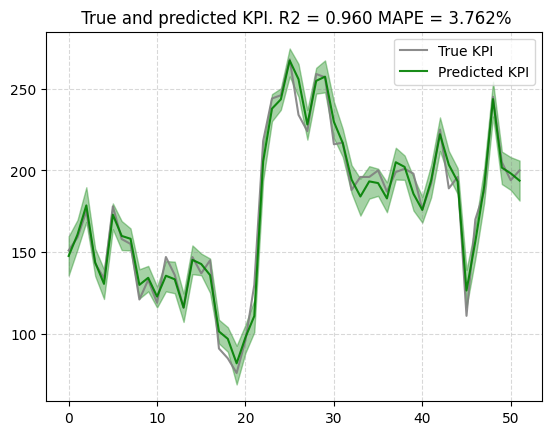

In [46]:
plot.plot_model_fit(mmm, target_scaler=target_scaler)

In [47]:
# media_data_test = jnp.nan_to_num(media_data_test, 0.0)
# We have to scale the test media data if we have not done so before.
# new_predictions = mmm.predict(media=media_scaler.transform(media_data_test))
# new_predictions.shape

In [48]:

# We have to scale the test media data if we have not done so before.
new_predictions = mmm.predict(media=media_scaler.transform(media_data_test),
                              extra_features=extra_features_scaler.transform(extra_features_test),seed=SEED)
new_predictions.shape

(200, 13)

In [49]:
new_predictions

Array([[1.0838623 , 0.9477813 , 0.93924177, ..., 1.3443915 , 1.1234428 ,
        1.0315924 ],
       [1.1077102 , 1.0032482 , 0.9901732 , ..., 1.4985459 , 1.2634461 ,
        1.1782653 ],
       [1.1041648 , 0.95795876, 0.91659814, ..., 1.2687155 , 1.1801738 ,
        0.99252033],
       ...,
       [1.0884833 , 0.96340036, 0.9697027 , ..., 1.4536078 , 1.1792831 ,
        1.113389  ],
       [1.1104895 , 0.92689884, 0.9656197 , ..., 1.423977  , 1.1459149 ,
        1.0129088 ],
       [1.0346409 , 0.87619674, 0.87331355, ..., 1.3488743 , 1.1376638 ,
        1.0049398 ]], dtype=float32)

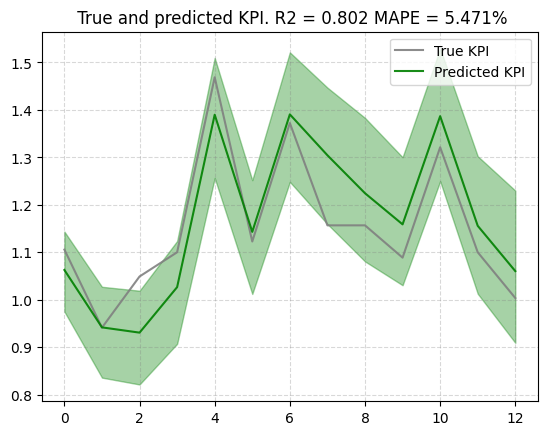

In [50]:
plot.plot_out_of_sample_model_fit(out_of_sample_predictions=new_predictions,
                                 out_of_sample_target=target_scaler.transform(target[split_point:].squeeze()))

In [ ]:
## Need to troubleshoot
# plot.plot_out_of_sample_model_fit(out_of_sample_predictions=new_predictions,
#                                  out_of_sample_target=target_scaler.transform(target[split_point:]))

In [52]:
# remove the "mdsp_" tag for proper labelling in charts 
channel_names = [col.replace('mdsp_', '').title() for col in media_cols]

In [53]:
media_contribution, roi_hat = mmm.get_posterior_metrics(target_scaler=target_scaler, cost_scaler=cost_scaler)

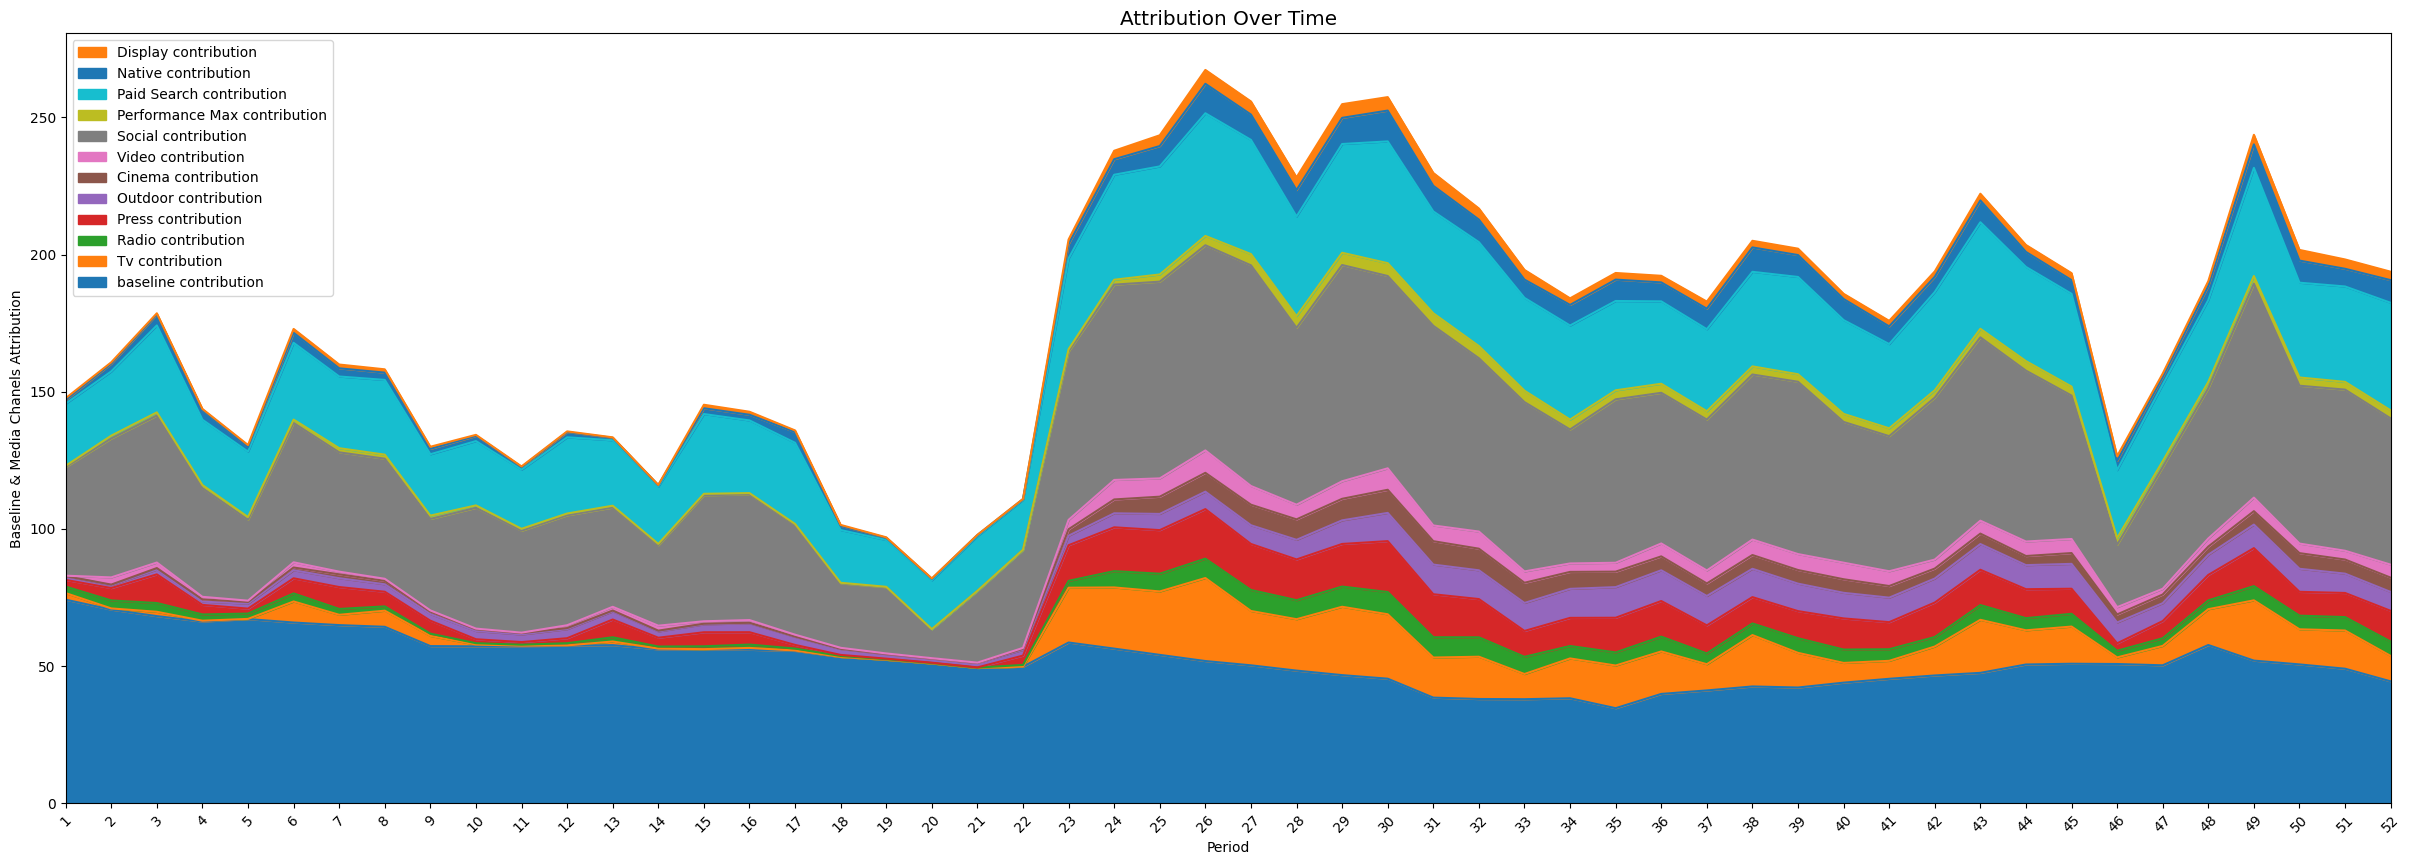

In [54]:
#channel_names = media_cols

from lightweight_mmm import plot

plot.plot_media_baseline_contribution_area_plot(
    media_mix_model=mmm,
    target_scaler=target_scaler,
    channel_names=channel_names,
    fig_size=(30, 10)
)


In [55]:
# Set Together template 
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

together_template = dict(
    layout=go.Layout(
        title_font=dict(family="Riforma LL", size=32,),
        title_pad=dict(b=48,),
        title_x=0.05, title_y=0.95, 
        legend_font=dict(family="Riforma LL", size=18,),
        font=dict(family="Riforma LL",),
    )
)


In [56]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.colors import qualitative
from lightweight_mmm import plot

# Extract the contribution data
contribution_df = plot.create_media_baseline_contribution_df(
    media_mix_model=mmm,
    target_scaler=target_scaler,
    channel_names=channel_names
)

# Create a date column
date_range = pd.date_range(start=start_date, periods=len(contribution_df), freq='W')
contribution_df['date'] = date_range

# Identify contribution columns
contribution_cols = [col for col in contribution_df.columns if 'contribution' in col]
baseline_col = [col for col in contribution_cols if 'baseline' in col][0]
media_cols = [col for col in contribution_cols if 'baseline' not in col]
ordered_cols = [baseline_col] + media_cols

# Clean legend labels
legend_labels = {
    col: col.replace('mdsp_', '').replace(' contribution', '').title()
    for col in ordered_cols
}

# Convert to long format
long_df = contribution_df.melt(
    id_vars='date',
    value_vars=ordered_cols,
    var_name='Channel',
    value_name='Contribution'
)

long_df['Channel_clean'] = long_df['Channel'].map(legend_labels)

# Use a more distinct, deeper palette
palette = qualitative.Dark24  # A large, distinct set of colors
# Option 5: Alphabet colors
#palette = qualitative.Alphabet  # 26 colors
#palette = qualitative.Light24  # 24 colors
#palette = qualitative.Vivid  # 12 colors
# Option 1: Plotly's default colors
#palette = qualitative.Plotly  # 10 colors
# Option 2: Set1 - Bright, distinct colors
#palette = qualitative.Set1  # 9 colors
# Option 3: Bold colors
#palette = qualitative.Bold  # 8 colors

num_colors = len(palette)
unique_channels = long_df['Channel_clean'].unique()

# Dynamically assign colors to channels from the Dark24 palette
channel_colors = {
    channel: palette[i % num_colors]
    for i, channel in enumerate(unique_channels)
}

# Force Baseline to be grey
if "Baseline" in channel_colors:
    channel_colors["Baseline"] = "#666666" # "#484848" #"#7F7F7F"  # a neutral grey color

# Create the area chart
fig = px.area(
    long_df,
    x='date',
    y='Contribution',
    color='Channel_clean',
    title=f"{target_variable_title}: Media and Baseline Contributions Over Time",
    labels={'Contribution': 'Contribution', 'Channel_clean': 'Channel', 'date': 'Date'},
    width=1500,
    height=600,
    template='plotly_white',
    color_discrete_map=channel_colors
)

# Update layout with preferred styling
fig.update_layout(
    go.Layout(
        title_font=dict(family="Riforma LL", size=32),
        title_pad=dict(b=48),
        title_x=0.05,
        title_y=0.95,
        legend_font=dict(family="Riforma LL", size=18),
        font=dict(family="Riforma LL"),
        xaxis_title="Date",
        yaxis_title=f"Contribution to {target_variable_title}",
        legend_title="Channel",
        showlegend=True,
        xaxis=dict(
            tickformat="%b %Y",
            tickangle=45,
            tickmode='auto',
            nticks=20
        )
    )
)

fig.show()


In [57]:
# Extract the contribution data
contribution_df = plot.create_media_baseline_contribution_df(
   media_mix_model=mmm,
   target_scaler=target_scaler,
   channel_names=channel_names
)
# Create a date column
date_range = pd.date_range(start=start_date, periods=len(contribution_df), freq='W')
contribution_df['date'] = date_range

# Filter data from start_date 
contribution_df = contribution_df[contribution_df['date'] >= start_date]


Media Contribution

In [58]:
# Media spend fraction or media % investment by channel
spend_fractions*100

,fraction of spend
mdsp_display,2.970000
mdsp_native,1.110000
mdsp_paid search,6.470000
mdsp_performance max,0.690000
mdsp_social,11.820000
mdsp_video,3.120000
mdsp_cinema,2.660000
mdsp_outdoor,6.820000
mdsp_press,23.309999
mdsp_radio,11.040000


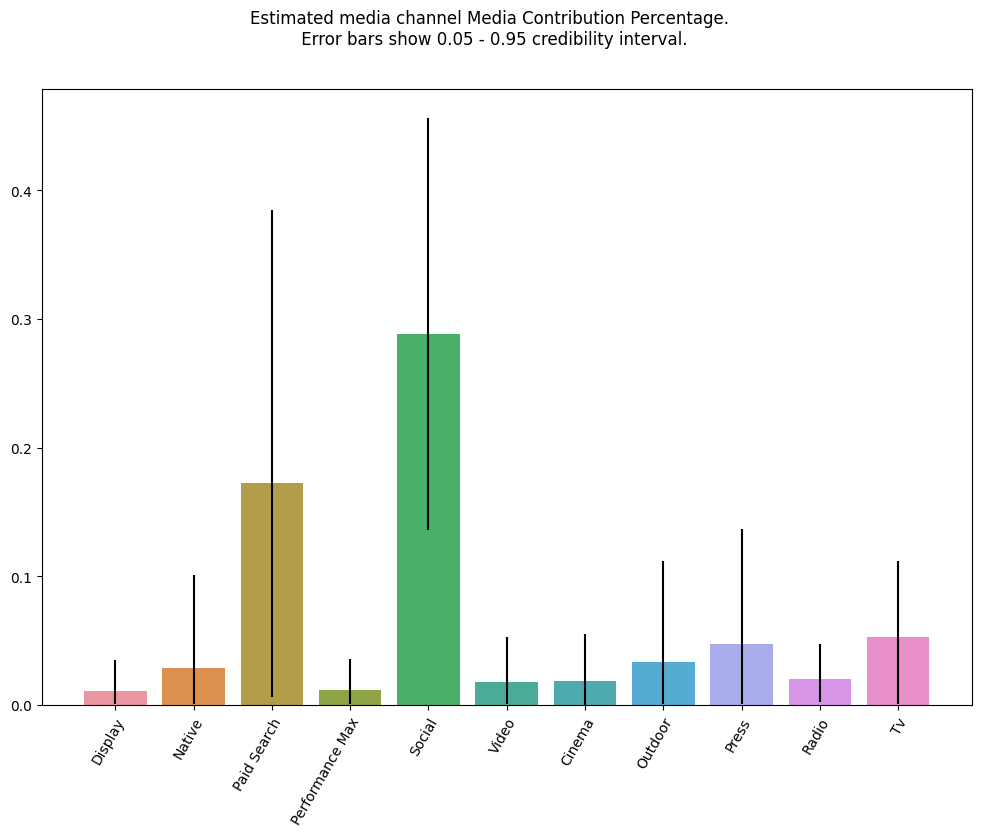

In [59]:
# plot.plot_bars_media_metrics(metric=media_contribution, channel_names=channel_names,
#                              metric_name="Media Contribution Percentage")

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plot.plot_bars_media_metrics(
    metric=media_contribution,
    channel_names=channel_names,
    metric_name="Media Contribution Percentage")

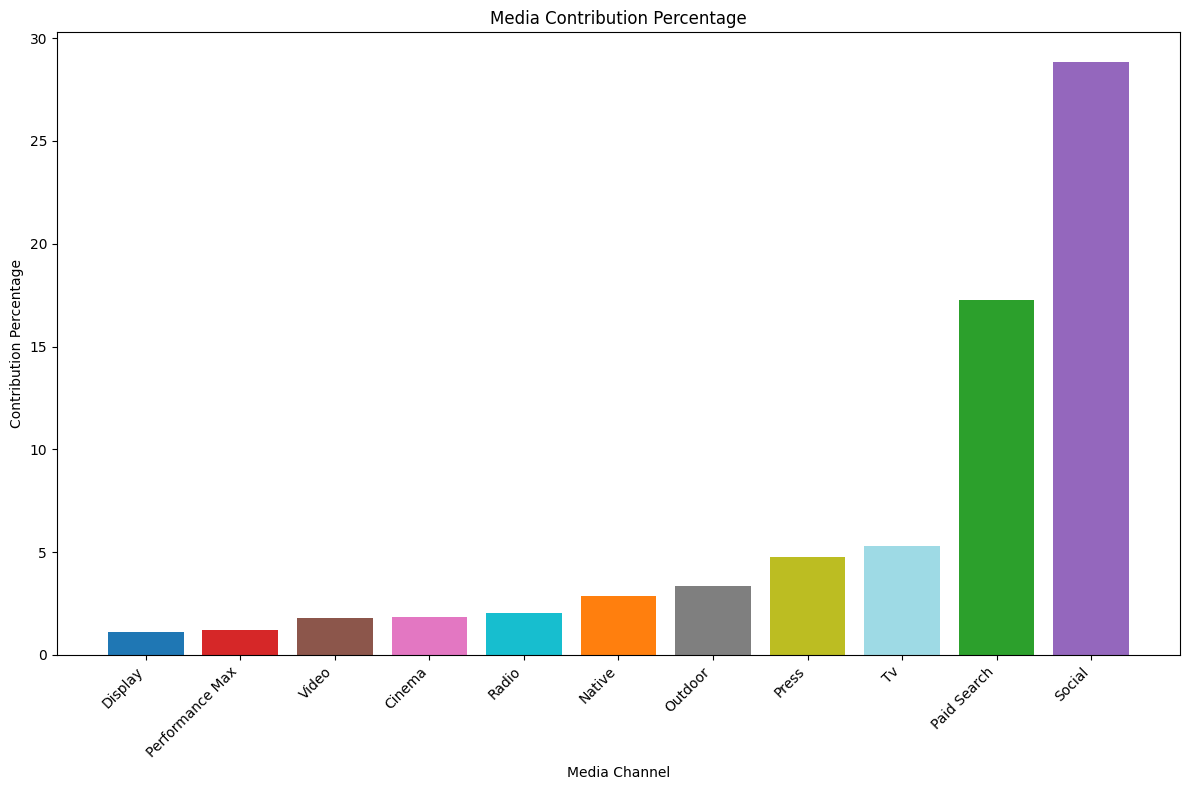

In [60]:
# Calculate mean of media contribution across samples
mean_contribution = np.mean(media_contribution, axis=0)

# Sort the contributions and get the sorting indices
sort_indices = np.argsort(mean_contribution)
mean_contribution_sorted = mean_contribution[sort_indices]*100
channel_names_sorted = [channel_names[i] for i in sort_indices]

# Create a colormap with unique colors
# You can try different colormaps like 'tab20', 'Set3', 'Paired', etc.
colors = plt.cm.tab20(np.linspace(0, 1, len(mean_contribution)))
colors_sorted = colors[sort_indices]

# Create the plot with unique colors
plt.figure(figsize=(12, 8))
plt.bar(range(len(mean_contribution_sorted)), 
        mean_contribution_sorted,
        color=colors_sorted)  # Add the sorted colors here

plt.title("Media Contribution Percentage")
plt.xlabel("Media Channel")
plt.ylabel("Contribution Percentage")

# Rotate and align the tick labels so they look better
plt.xticks(range(len(mean_contribution_sorted)), 
           channel_names_sorted, 
           rotation=45, 
           ha='right')

# Use tight_layout to prevent label cutoff
plt.tight_layout()
plt.show()

# Create DataFrame with channel names and contribution percentages
contribution_df = pd.DataFrame({
    'Channel': channel_names_sorted,
    'Contribution_Percentage': mean_contribution_sorted
})

In [61]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np

# Define a consistent color palette for broader categories
channel_colors = {
    'Baseline': '#1f77b4',  # Blue
    'Display': '#d62728',  # Red
    'Native': '#e377c2',   # Pink
    'Paid Search': '#17becf',  # Cyan
    'Performance Max': '#1a55FF',  # Bright blue
    'Social': '#FF4444',   # Bright red
    'Video': '#00cccc',    # Turquoise
    'Cinema': '#44FF44',   # Lime
    'Outdoor': '#4444FF',  # Royal blue
    'Press': '#FF44FF',    # Hot pink
    'Radio': '#44FFFF',    # Light blue
    'Tv': '#FF9999',       # Light red
}

# Define Together template
together_template = dict(
    layout=go.Layout(
        title_font=dict(family="Riforma LL", size=32,),
        title_pad=dict(b=48,),
        title_x=0.05, title_y=0.95, 
        legend_font=dict(family="Riforma LL", size=18,),
        font=dict(family="Riforma LL",),
    )
)

# Calculate mean of media contribution across samples
mean_contribution = np.mean(media_contribution, axis=0)

# Sort the contributions and get the sorting indices
sort_indices = np.argsort(mean_contribution)
mean_contribution_sorted = mean_contribution[sort_indices]
channel_names_sorted = [channel_names[i] for i in sort_indices]

# Create DataFrame for plotting
df = pd.DataFrame({
    'Channel': channel_names_sorted,
    'Contribution': mean_contribution_sorted
})

# Clean channel names and create a mapping for colors
df['Channel_Clean'] = df['Channel'].apply(lambda x: x.replace('mdsp_', '').replace(' ', ' '))
df['Channel_Display'] = df['Channel'].apply(lambda x: x.replace('mdsp_', '').title())

# Create the bar plot using Graph Objects for more control
fig = go.Figure()

# Add bars with consistent colors
fig.add_trace(go.Bar(
    x=df['Channel_Display'],
    y=df['Contribution'],
    marker_color=[channel_colors[channel] for channel in df['Channel_Clean']],
    marker_line_color='rgb(8,48,107)',  # Add border to bars
    marker_line_width=1.5,              # Border width
    hovertemplate="<b>%{x}</b><br>" +
                  "Contribution: %{y:.2%}<br>" +
                  "<extra></extra>"
))

# Update layout using template
fig.update_layout(
    together_template['layout'],
    title=f"Qualified Leads: Media Contribution Percentage",
    #title=f"{target_variable_title}: Media Contribution Percentage",
    xaxis_title="Media Channel",
    yaxis_title="Contribution Percentage",
    width=1200,
    height=600,
    template='plotly_white',
    xaxis=dict(
        tickangle=45,
        type='category'
    ),
    yaxis=dict(
        tickformat='.1%',  # Format y-axis as percentage
        gridcolor='rgba(0,0,0,0.1)'  # Lighter grid lines
    ),
    bargap=0.2,
    showlegend=False
)

# Add value labels on top of bars
for i in range(len(df)):
    fig.add_annotation(
        x=df['Channel_Display'].iloc[i],
        y=df['Contribution'].iloc[i],
        text= "", #f"{df['Contribution'].iloc[i]:.1%}",
        yshift=10,
        showarrow=False,
        font=dict(
            family="Riforma LL",
            size=12,
        )
    )

# Show the plot
fig.show()

# Print summary statistics
print("\nContribution Summary:")
print("-" * 50)
print(f"Total contribution: {df['Contribution'].sum():.1%}")
print(f"Highest contributing channel: {df['Channel_Display'].iloc[-1]} ({df['Contribution'].iloc[-1]:.1%})")
print(f"Lowest contributing channel: {df['Channel_Display'].iloc[0]} ({df['Contribution'].iloc[0]:.1%})")


Contribution Summary:
--------------------------------------------------
Total contribution: 70.4%
Highest contributing channel: Social (28.8%)
Lowest contributing channel: Display (1.1%)


Return on Investment

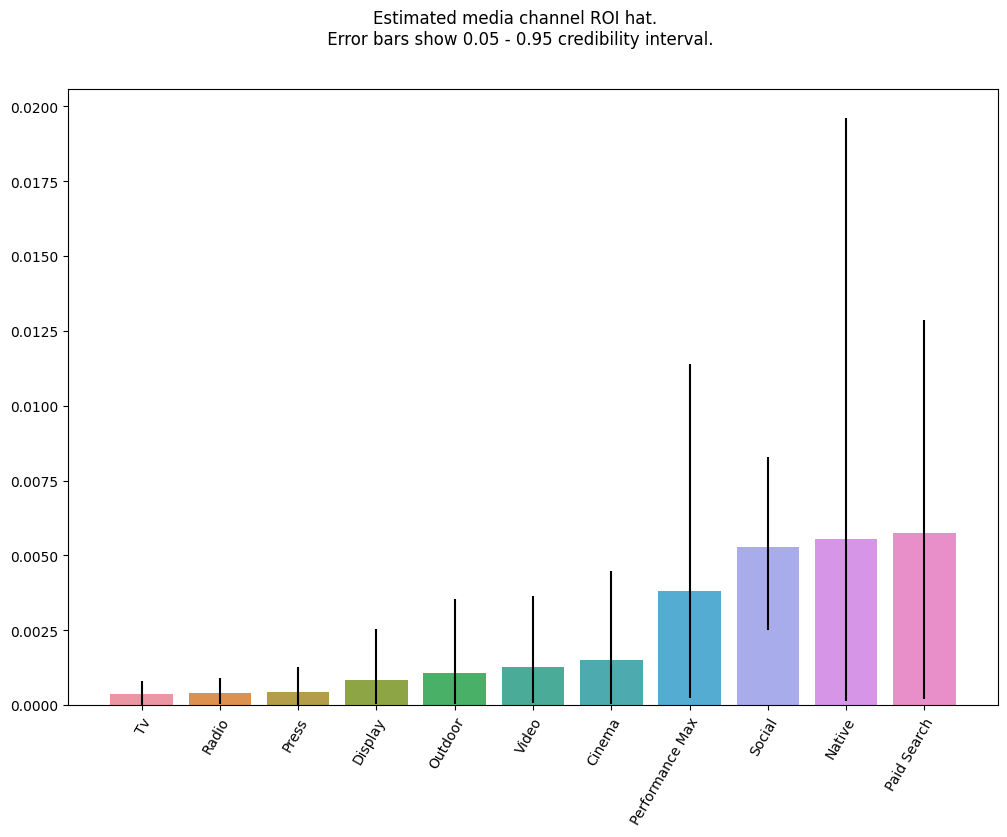

In [104]:
# ROI
# Sort ROI values
sort_indices = np.argsort(np.mean(roi_hat, axis=0))
roi_hat_sorted = roi_hat[:, sort_indices]
channel_names_sorted = [channel_names[i] for i in sort_indices]

plot.plot_bars_media_metrics(metric=roi_hat_sorted, channel_names=channel_names_sorted,
                           metric_name="ROI hat")

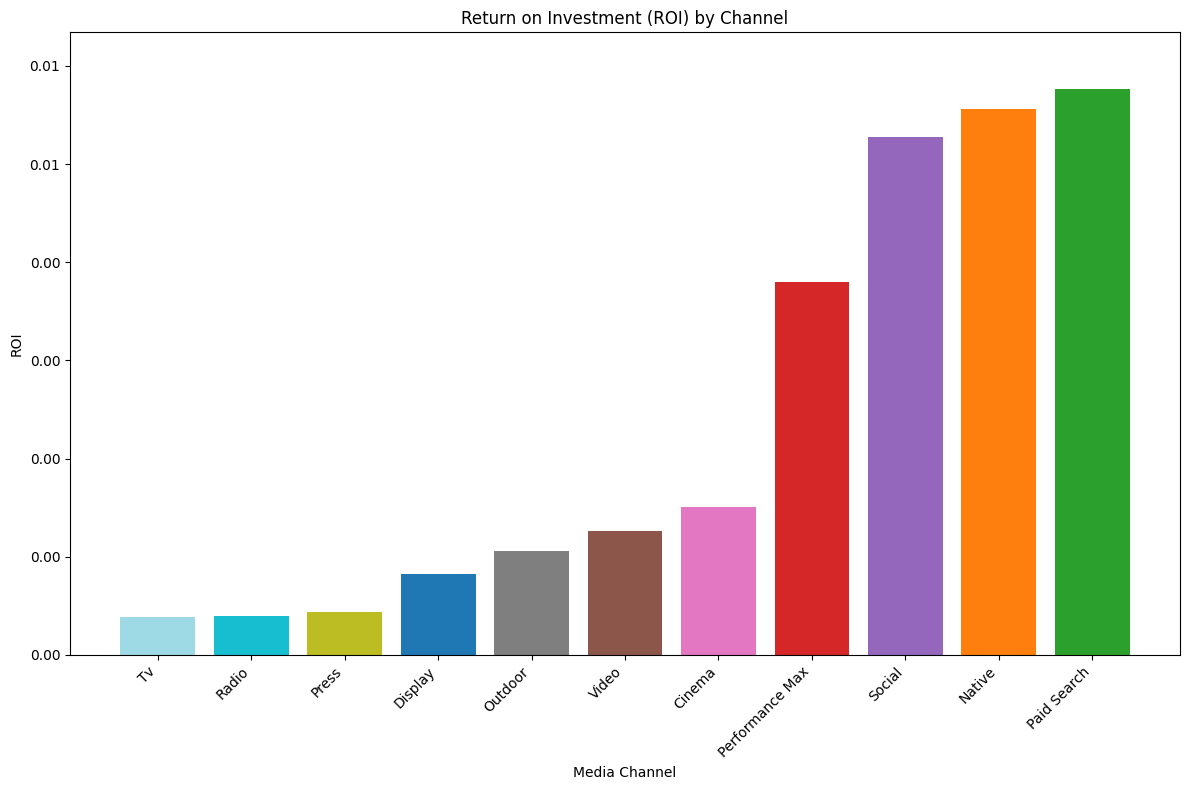


ROI Summary:
--------------------------------------------------
Average ROI across channels: 0.002389
Highest ROI: 0.005766 (Paid Search)
Lowest ROI: 0.000383 (Tv)


In [63]:
# Calculate mean of ROI across samples
mean_roi = np.mean(roi_hat, axis=0)

# Sort the ROI values and get the sorting indices
sort_indices = np.argsort(mean_roi)
mean_roi_sorted = mean_roi[sort_indices]
channel_names_sorted = [channel_names[i] for i in sort_indices]

# Create a colormap with unique colors
colors = plt.cm.tab20(np.linspace(0, 1, len(mean_roi)))
colors_sorted = colors[sort_indices]

# Create the plot with unique colors
plt.figure(figsize=(12, 8))
plt.bar(range(len(mean_roi_sorted)), 
        mean_roi_sorted,
        color=colors_sorted)

plt.title("Return on Investment (ROI) by Channel")
plt.xlabel("Media Channel")
plt.ylabel("ROI")

# Clean up channel names by removing 'mdsp_' prefix and capitalizing
channel_names_cleaned = [name.replace('mdsp_', '').title() for name in channel_names_sorted]

# Rotate and align the tick labels
plt.xticks(range(len(mean_roi_sorted)), 
           channel_names_cleaned, 
           rotation=45, 
           ha='right')

# Set y-axis limits to show small values clearly
max_roi = np.max(mean_roi_sorted)
plt.ylim(0, max_roi * 1.1)  # Set upper limit to 110% of max value

# Format y-axis ticks to show small decimals
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))

# Use tight_layout to prevent label cutoff
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nROI Summary:")
print("-" * 50)
print(f"Average ROI across channels: {np.mean(mean_roi):.6f}")
print(f"Highest ROI: {np.max(mean_roi):.6f} ({channel_names_cleaned[len(channel_names_cleaned)-1]})")
print(f"Lowest ROI: {np.min(mean_roi):.6f} ({channel_names_cleaned[0]})")

# Save the data to a CSV file
import pandas as pd

# Create DataFrame with channel names and ROI values
roi_df = pd.DataFrame({
    'Channel': channel_names_cleaned,
    'ROI': mean_roi_sorted
})

# # Save to CSV
# roi_df.to_csv('d:/downloads/channel_roi_values.csv', index=False)

#### Optimization

In [66]:
# Get total media cost 
prices = jnp.ones(mmm.n_media_channels)
prices

Array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)

In [67]:
n_time_periods = 12  # number of weeks Forecast period 
budget = jnp.sum(jnp.dot(prices, media_data.mean(axis=0)))* n_time_periods  # media budget over the next FY period
budget

In [69]:
# Run optimization with the parameters of choice.
solution, kpi_without_optim, previous_budget_allocation = optimize_media.find_optimal_budgets(
    n_time_periods=n_time_periods,
    media_mix_model=mmm,
    extra_features=extra_features_scaler.transform(extra_features_test)[:n_time_periods],
    budget=budget,
    prices=prices,
    media_scaler=media_scaler,
    target_scaler=target_scaler,
    seed=SEED
    )

Optimization terminated successfully    (Exit mode 0)
            Current function value: -2302.5079810900475
            Iterations: 58
            Function evaluations: 1334
            Gradient evaluations: 58


In [70]:
# Obtain the optimal weekly allocation.
optimal_buget_allocation = prices * solution.x
optimal_buget_allocation

Array([ 21291.041,   9717.143,  58853.5  ,   6030.954, 106513.67 ,
        26967.828,  21790.68 ,  49564.945, 181246.5  ,  79727.414,
       222067.52 ], dtype=float32)

#### Plot the following:
1. Pre post optimization budget allocation comparison for each channel
2. Pre post optimization predicted target variable comparison

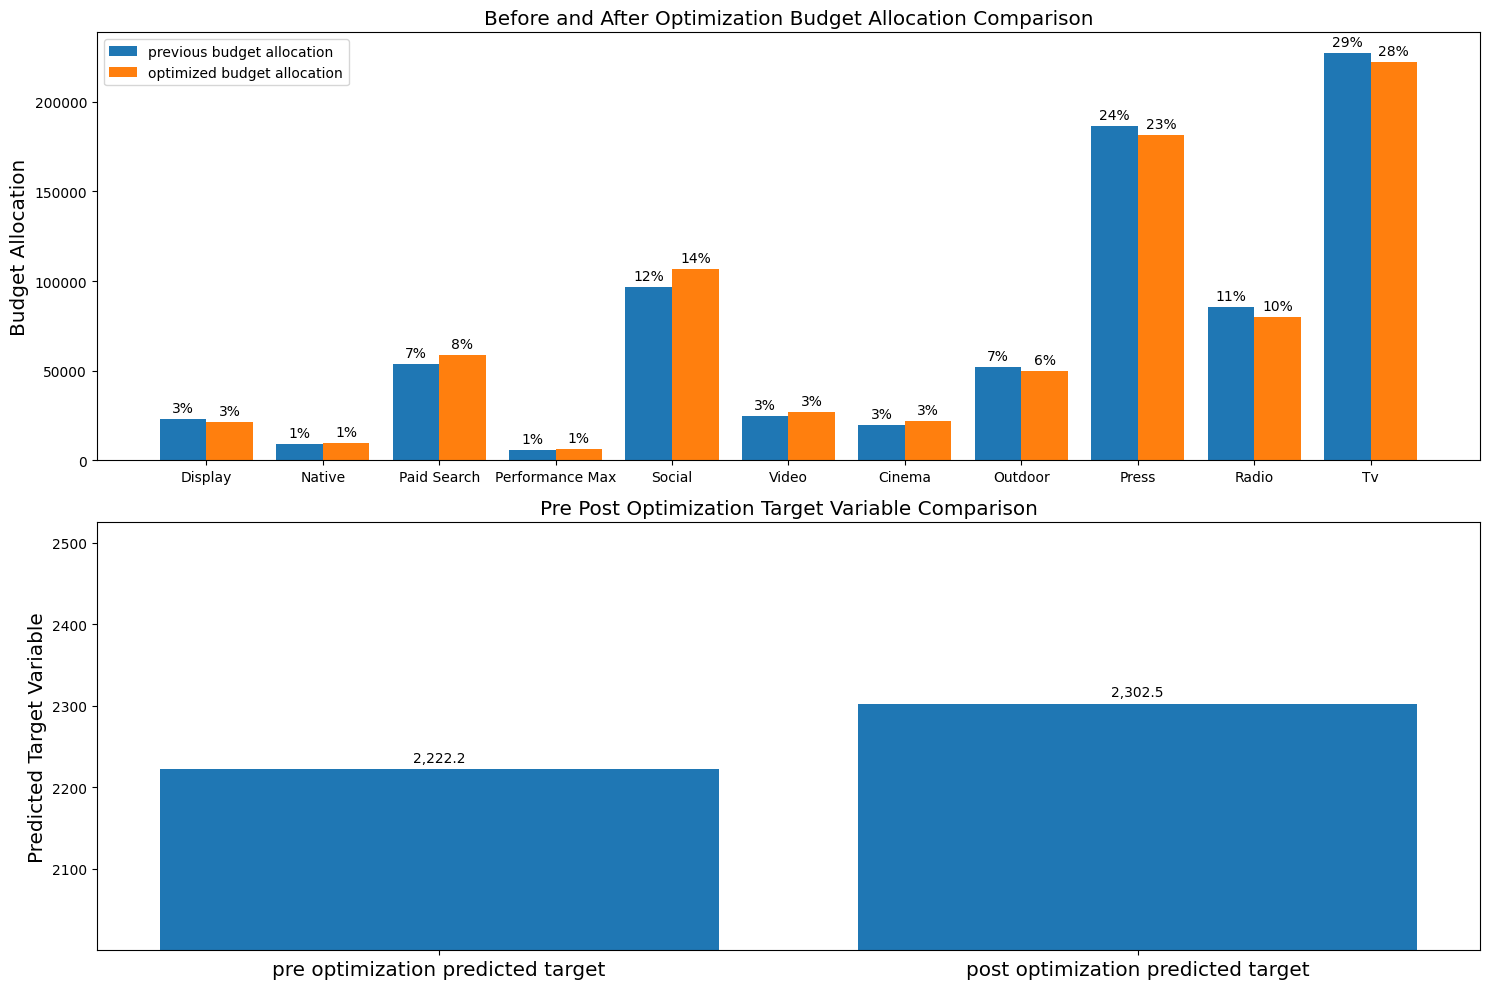

In [71]:
# Question 6: What is the optimal allocation of budget across channels to maximize sales?
# Chart Type/Measurement: Optimization model output visualized as a bar chart of recommended budget allocation.
# Plot out pre post optimization budget allocation and predicted target variable comparison.

plot.plot_pre_post_budget_allocation_comparison(media_mix_model=mmm,
                                                kpi_with_optim=solution['fun'],
                                                kpi_without_optim=kpi_without_optim,
                                                optimal_buget_allocation=optimal_buget_allocation,
                                                previous_budget_allocation=previous_budget_allocation,
                                                channel_names=channel_names,
                                                figure_size=(15,10))

In [72]:
previous_budget_allocation

Array([ 23071.133,   8834.343,  53506.668,   5483.043,  96836.92 ,
        24517.805,  19810.998,  51833.7  , 186756.11 ,  85678.195,
       227442.25 ], dtype=float32)

In [85]:
## Layer Improvement for KPI ### 
import pandas as pd

# Create DataFrame for comparison
comparison_df = pd.DataFrame({
    'Channel': [ch.replace('mdsp_', '').title() for ch in channel_names],
    'Previous Budget': previous_budget_allocation,
    'Optimal Budget': optimal_buget_allocation,
})

# Calculate differences and percentage changes
comparison_df['Absolute Change'] = comparison_df['Optimal Budget'] - comparison_df['Previous Budget']
comparison_df['Percentage Change'] = (comparison_df['Absolute Change'] / comparison_df['Previous Budget'] * 100)

# Sort by absolute change (optional)
comparison_df = comparison_df.sort_values('Absolute Change', ascending=False)

# Format currency columns
for col in ['Previous Budget', 'Optimal Budget', 'Absolute Change']:
    comparison_df[col] = comparison_df[col].apply(lambda x: f"${x:,.2f}")

# Format percentage column
comparison_df['Percentage Change'] = comparison_df['Percentage Change'].apply(lambda x: f"{x:,.1f}%")

# Calculate totals before formatting
total_previous = previous_budget_allocation.sum()
total_optimal = optimal_buget_allocation.sum()
total_change = total_optimal - total_previous
total_pct_change = ((total_optimal / total_previous) - 1) * 100

# Add totals row
comparison_df.loc['Total'] = [
    'Total',
    f"${total_previous:,.2f}",
    f"${total_optimal:,.2f}",
    f"${total_change:,.2f}",
    f"{total_pct_change:.1f}%"
]

# Calculate KPI improvement
kpi_improvement = ((solution['fun'] - kpi_without_optim) / kpi_without_optim) * 100

# Print the results in a formatted way
print("\nBudget Allocation Comparison")
print(f"KPI Improvement: {kpi_improvement:.1f}%")
print(f"Applications before optimization: {abs(int(kpi_without_optim))}")
print(f"Applications after optimization: {abs(int(solution['fun']))}")
print("-" * 100)
print("\nChannel Budget Analysis:")
print("-" * 100)
print(comparison_df.to_string())
print("-" * 100)

# Optional: Save to Excel with formatting
#comparison_df.to_excel('d:/downloads/budget_comparison.xlsx', index=False)


Budget Allocation Comparison
KPI Improvement: 3.6%
Applications before optimization: 2222
Applications after optimization: 2302
----------------------------------------------------------------------------------------------------

Channel Budget Analysis:
----------------------------------------------------------------------------------------------------
               Channel Previous Budget Optimal Budget Absolute Change Percentage Change
4               Social      $96,836.92    $106,513.67       $9,676.75             10.0%
2          Paid Search      $53,506.67     $58,853.50       $5,346.83             10.0%
5                Video      $24,517.80     $26,967.83       $2,450.02             10.0%
6               Cinema      $19,811.00     $21,790.68       $1,979.68             10.0%
1               Native       $8,834.34      $9,717.14         $882.80             10.0%
3      Performance Max       $5,483.04      $6,030.95         $547.91             10.0%
0              Display     

In [86]:
import pandas as pd

# Create DataFrame for comparison
comparison_df = pd.DataFrame({
    'Channel': [ch.replace('mdsp_', '').title() for ch in channel_names],
    'Previous Share': (previous_budget_allocation / previous_budget_allocation.sum()) * 100,
    'Optimal Share': (optimal_buget_allocation / optimal_buget_allocation.sum()) * 100,
})

# Calculate share differences
comparison_df['Share Change'] = comparison_df['Optimal Share'] - comparison_df['Previous Share']

# Sort by share change (optional)
comparison_df = comparison_df.sort_values('Share Change', ascending=False)

# Format percentage columns
for col in ['Previous Share', 'Optimal Share', 'Share Change']:
    comparison_df[col] = comparison_df[col].apply(lambda x: f"{x:.4f}%")

# Add totals row
comparison_df.loc['Total'] = [
    'Total',
    '100.0%',
    '100.0%',
    '0.0%'
]

# Calculate KPI improvement
kpi_improvement = ((solution['fun'] - kpi_without_optim) / kpi_without_optim) * 100

# Print the results in a formatted way
print("\nBudget Share Allocation Comparison")
print(f"KPI Improvement: {kpi_improvement:.1f}%")
print("-" * 100)
print("\nChannel Share Analysis:")
print("-" * 100)
print(comparison_df.to_string())
print("-" * 100)

# Optional: Save to Excel with formatting
#comparison_df.to_excel('d:/downloads/leads-budget_share_comparison.xlsx', index=False)


Budget Share Allocation Comparison
KPI Improvement: 3.6%
----------------------------------------------------------------------------------------------------

Channel Share Analysis:
----------------------------------------------------------------------------------------------------
               Channel Previous Share Optimal Share Share Change
4               Social       12.3553%      13.5899%      1.2346%
2          Paid Search        6.8268%       7.5090%      0.6822%
5                Video        3.1282%       3.4408%      0.3126%
6               Cinema        2.5277%       2.7802%      0.2526%
1               Native        1.1272%       1.2398%      0.1126%
3      Performance Max        0.6996%       0.7695%      0.0699%
0              Display        2.9436%       2.7165%     -0.2271%
7              Outdoor        6.6134%       6.3239%     -0.2895%
10                  Tv       29.0190%      28.3332%     -0.6857%
8                Press       23.8279%      23.1249%     -0.7030%


In [87]:
comparison_df

,Channel,Previous Share,Optimal Share,Share Change
4,Social,12.3553%,13.5899%,1.2346%
2,Paid Search,6.8268%,7.5090%,0.6822%
5,Video,3.1282%,3.4408%,0.3126%
6,Cinema,2.5277%,2.7802%,0.2526%
1,Native,1.1272%,1.2398%,0.1126%
3,Performance Max,0.6996%,0.7695%,0.0699%
0,Display,2.9436%,2.7165%,-0.2271%
7,Outdoor,6.6134%,6.3239%,-0.2895%
10,Tv,29.0190%,28.3332%,-0.6857%
8,Press,23.8279%,23.1249%,-0.7030%


Decay Rate of Media Channels

In [90]:
# Visualize media channel decay rates over time 
# Show how each channel's effect diminishes over weeks
# Calculate and display retention rates, peak delays and half-life for each channel

import plotly.express as px
import numpy as np

# Get the retention rates and peak delay parameters
retention_rates = mmm.trace['ad_effect_retention_rate'].mean(axis=0)
peak_delays = mmm.trace['peak_effect_delay'].mean(axis=0)

# Create time points for visualization
weeks = np.arange(12)

# Clean channel names
clean_channel_names = [ch.replace('mdsp_', '').title() for ch in channel_names]

# Calculate decay curves for each channel
decay_curves = {}
for i, channel in enumerate(clean_channel_names):  # Use clean names here
    retention = retention_rates[i]
    peak_delay = peak_delays[i]
    time_effect = np.power(retention, weeks) * 100  # Multiply by 100
    decay_curves[channel] = time_effect

# Create DataFrame for plotting
decay_df = pd.DataFrame(decay_curves)
decay_df['Week'] = weeks

# Melt the DataFrame for plotting
decay_df_melted = decay_df.melt(
    id_vars=['Week'],
    var_name='Channel',
    value_name='Carryover Effect'
) 

# Create plot
fig = px.line(
    decay_df_melted,
    x='Week',
    y='Carryover Effect',
    color='Channel',
    title=f"{target_variable_title}: Decay Rate of Media Investment Channels",
    markers=True
)

# Update layout using Together template
fig.update_layout(
    title_font=dict(family="Riforma LL", size=32),
    title_pad=dict(b=48),
    title_x=0.05, 
    title_y=0.95,
    legend_font=dict(family="Riforma LL", size=18),
    font=dict(family="Riforma LL"),
    xaxis_title='Weeks',
    yaxis_title='Decay Rate (%)', 
    template='plotly_white',
    height=600,
    width=1000,
    showlegend=True,
    legend_title='Channel',
    yaxis=dict(range=[0, 100]) 
)

# Show the plot
fig.show()

# Print analysis of carryover effects with clean names
print("\nCarryover Effect Analysis:")
print("-" * 50)
for i, channel in enumerate(clean_channel_names):  # Use clean names here
    retention = retention_rates[i]
    peak_delay = peak_delays[i]
    half_life = -np.log(2)/np.log(retention) if retention > 0 else 0
    
    print(f"\n{channel}:")
    print(f"Retention Rate: {retention:.3f}")
    print(f"Peak Effect Delay: {peak_delay:.1f} weeks")
    print(f"Half-life: {half_life:.1f} weeks")


Carryover Effect Analysis:
--------------------------------------------------

Display:
Retention Rate: 0.491
Peak Effect Delay: 1.3 weeks
Half-life: 1.0 weeks

Native:
Retention Rate: 0.480
Peak Effect Delay: 1.2 weeks
Half-life: 0.9 weeks

Paid Search:
Retention Rate: 0.283
Peak Effect Delay: 0.6 weeks
Half-life: 0.5 weeks

Performance Max:
Retention Rate: 0.531
Peak Effect Delay: 1.8 weeks
Half-life: 1.1 weeks

Social:
Retention Rate: 0.064
Peak Effect Delay: 0.1 weeks
Half-life: 0.3 weeks

Video:
Retention Rate: 0.443
Peak Effect Delay: 1.2 weeks
Half-life: 0.9 weeks

Cinema:
Retention Rate: 0.584
Peak Effect Delay: 1.5 weeks
Half-life: 1.3 weeks

Outdoor:
Retention Rate: 0.596
Peak Effect Delay: 2.2 weeks
Half-life: 1.3 weeks

Press:
Retention Rate: 0.354
Peak Effect Delay: 0.8 weeks
Half-life: 0.7 weeks

Radio:
Retention Rate: 0.499
Peak Effect Delay: 1.1 weeks
Half-life: 1.0 weeks

Tv:
Retention Rate: 0.230
Peak Effect Delay: 0.6 weeks
Half-life: 0.5 weeks


#### Scenario Planning for FY2025

In [94]:
# ### MONTHLY FORECAST ###

# import numpy as np
# import jax.numpy as jnp
# from sklearn.preprocessing import StandardScaler

# def optimize_budget_for_target(target_applications_monthly, mmm, media_scaler, target_scaler, total_budget=None):
#     """
#     Find optimal budget allocation to achieve target monthly application volume.
#     """
#     # Convert monthly target to weekly (assuming 4.33 weeks per month)
#     WEEKS_PER_MONTH = 4.33
#     target_applications_weekly = target_applications_monthly / WEEKS_PER_MONTH
    
#     # Adjust monthly budget to weekly if provided
#     weekly_budget = total_budget / WEEKS_PER_MONTH if total_budget is not None else None
    
#     # Guardrail: Check if the weekly budget is less than threshold
#     if weekly_budget is not None and weekly_budget < investment_threshold:
#         print("\nWarning: Weekly budget is too low.")
#         print(f"Please provide a monthly budget of at least ${investment_threshold * WEEKS_PER_MONTH:,.2f}")
#         print(f"Current monthly budget: ${total_budget:,.2f}")
#         print(f"Current weekly budget: ${weekly_budget:,.2f}")
#         return None

#     # Get model components using the same approach as out-of-sample predictions
#     media_contribution, roi_hat = mmm.get_posterior_metrics(
#         target_scaler=target_scaler,
#         cost_scaler=cost_scaler
#     )

#     # Get coefficients from the media contribution
#     media_coefficients = media_contribution.mean(axis=0)
#     intercept = float(mmm.trace['intercept'].mean())
    
#     # Get response curves parameters
#     retention_rates = np.array(mmm.trace['ad_effect_retention_rate'].mean(axis=0))
#     peak_delays = np.array(mmm.trace['peak_effect_delay'].mean(axis=0))
    
#     try:
#         # Convert target applications to numpy array and reshape
#         target_apps_array = np.array([[target_applications_weekly]], dtype=np.float64)
        
#         # Scale target applications
#         target_scaled = target_scaler.transform(target_apps_array)[0][0]
        
#         # Calculate contribution needed from media (subtract intercept)
#         media_contribution_needed = float(target_scaled - intercept)
        
#         # Calculate relative channel effectiveness
#         channel_effectiveness = np.array(media_coefficients * retention_rates)
        
#         # Normalize effectiveness to get proportions
#         total_effectiveness = np.sum(channel_effectiveness)
#         if total_effectiveness > 0:
#             effectiveness_proportions = channel_effectiveness / total_effectiveness
#         else:
#             effectiveness_proportions = np.ones_like(channel_effectiveness) / len(channel_effectiveness)
        
#         # Calculate budget allocation
#         if weekly_budget is not None:
#             optimal_budgets = effectiveness_proportions * float(weekly_budget)
#         else:
#             # Estimate required total budget based on model parameters
#             avg_response_per_dollar = np.mean(media_coefficients)
#             if avg_response_per_dollar > 0:
#                 estimated_total_budget = media_contribution_needed / avg_response_per_dollar
#                 optimal_budgets = effectiveness_proportions * float(estimated_total_budget)
#             else:
#                 optimal_budgets = np.zeros_like(effectiveness_proportions)
        
#         # Create budget dictionary
#         budget_allocation = {}
#         for i, channel in enumerate(channel_names):
#             clean_name = channel.replace('mdsp_', '').title()
#             # Use np.maximum instead of max
#             budget_allocation[clean_name] = float(np.maximum(0, optimal_budgets[i]))
        
#         # Verify the allocation using the estimation function
#         estimated_apps = estimate_applications(
#             budget_allocation,
#             mmm,
#             media_scaler,
#             target_scaler
#         )
        
#         # Create channel effectiveness dictionary
#         effectiveness_dict = {
#             channel.replace('mdsp_', '').title(): float(eff)
#             for channel, eff in zip(channel_names, effectiveness_proportions)
#         }
        
#         # Convert weekly figures to monthly
#         monthly_budget_allocation = {
#             channel: budget * WEEKS_PER_MONTH 
#             for channel, budget in budget_allocation.items()
#         }
        
#         return {
#             'optimal_budgets': monthly_budget_allocation,
#             'estimated_applications': float(estimated_apps * WEEKS_PER_MONTH),
#             'target_applications': float(target_applications_monthly),
#             'total_spend': float(sum(monthly_budget_allocation.values())),
#             'channel_effectiveness': effectiveness_dict
#         }
        
#     except Exception as e:
#         print(f"Error in optimization: {str(e)}")
#         print(f"Debug info:")
#         print(f"Target applications shape: {target_apps_array.shape}")
#         print(f"Media coefficients shape: {media_coefficients.shape}")
#         print(f"Retention rates shape: {retention_rates.shape}")
#         return None

# def estimate_applications(channel_budgets, mmm, media_scaler, target_scaler):
#     """
#     Estimate application volume for given channel budgets.
#     """
#     # Convert budget dictionary to array in correct channel order
#     media_spend = np.zeros((1, len(channel_names)))
#     for i, channel in enumerate(channel_names):
#         clean_name = channel.replace('mdsp_', '').title()
#         media_spend[0, i] = channel_budgets.get(clean_name, 0)
    
#     # Scale the media spend
#     media_scaled = media_scaler.transform(media_spend)
    
#     # Get prediction
#     prediction = mmm.predict(media_scaled)
    
#     # Convert to actual volume
#     volume = float(target_scaler.inverse_transform(prediction.reshape(-1, 1)).flatten()[0])
    
#     return volume

# # Example usage
# investment_threshold = 4000  # Weekly minimum
# target_apps_monthly =1000  # Monthly target applications
# total_budget_monthly = 30900  # Monthly budget

# # Run optimization
# result = optimize_budget_for_target(
#     target_applications_monthly=target_apps_monthly,
#     mmm=mmm,
#     media_scaler=media_scaler,
#     target_scaler=target_scaler,
#     total_budget=total_budget_monthly
# )

# # Print results only if we got a valid result
# if result is not None:
#     print(f"\nMonthly Budget Allocation for Target Applications: {result['target_applications']:,.0f}")
#     print("-" * 60)
#     print(f"Estimated Monthly Applications: {result['estimated_applications']:,.0f}")
#     print(f"Total Monthly Budget: ${result['total_spend']:,.2f}")
#     print("\nMonthly Channel Budgets:")
#     for channel, budget in result['optimal_budgets'].items():
#         effectiveness = result['channel_effectiveness'][channel] * 100
#         print(f"{channel}: ${budget:,.2f} (Effectiveness: {effectiveness:.1f}%)")

#     # Print difference from target
#     diff = result['estimated_applications'] - result['target_applications']
#     print(f"\nMonthly difference from target: {diff:,.0f} applications")
#     print(f"Weekly difference from target: {diff/4.33:,.1f} applications")

In [95]:
### ANNUAL FORECAST PREDICTION ###
### ANNUAL FORECAST ###

import numpy as np
import jax.numpy as jnp
from sklearn.preprocessing import StandardScaler

def optimize_budget_for_target(target_applications_annual, mmm, media_scaler, target_scaler, total_budget=None):
    """
    Find optimal budget allocation to achieve target annual application volume.
    """
    # Convert annual target to weekly (assuming 52 weeks per year)
    
    weeks_per_year = 52
    target_applications_weekly = target_applications_annual / weeks_per_year
    
    # Adjust annual budget to weekly if provided
    weekly_budget = total_budget / weeks_per_year if total_budget is not None else None
    
    # Guardrail: Check if the weekly budget is less than threshold
    if weekly_budget is not None and weekly_budget < investment_threshold:
        print("\nWarning: Weekly budget is too low.")
        print(f"Please provide an annual budget of at least ${investment_threshold * weeks_per_year:,.2f}")
        print(f"Current annual budget: ${total_budget:,.2f}")
        print(f"Current weekly budget: ${weekly_budget:,.2f}")
        return None

    # Get model components using the same approach as out-of-sample predictions
    media_contribution, roi_hat = mmm.get_posterior_metrics(
        target_scaler=target_scaler,
        cost_scaler=cost_scaler
    )

    # Get coefficients from the media contribution
    media_coefficients = media_contribution.mean(axis=0)
    intercept = float(mmm.trace['intercept'].mean())
    
    # Get response curves parameters
    retention_rates = np.array(mmm.trace['ad_effect_retention_rate'].mean(axis=0))
    peak_delays = np.array(mmm.trace['peak_effect_delay'].mean(axis=0))
    
    try:
        # Convert target applications to numpy array and reshape
        target_apps_array = np.array([[target_applications_weekly]], dtype=np.float64)
        
        # Scale target applications
        target_scaled = target_scaler.transform(target_apps_array)[0][0]
        
        # Calculate contribution needed from media (subtract intercept)
        media_contribution_needed = float(target_scaled - intercept)
        
        # Calculate relative channel effectiveness
        channel_effectiveness = np.array(media_coefficients * retention_rates)
        
        # Normalize effectiveness to get proportions
        total_effectiveness = np.sum(channel_effectiveness)
        if total_effectiveness > 0:
            effectiveness_proportions = channel_effectiveness / total_effectiveness
        else:
            effectiveness_proportions = np.ones_like(channel_effectiveness) / len(channel_effectiveness)
        
        # Calculate budget allocation
        if weekly_budget is not None:
            optimal_budgets = effectiveness_proportions * float(weekly_budget)
        else:
            # Estimate required total budget based on model parameters
            avg_response_per_dollar = np.mean(media_coefficients)
            if avg_response_per_dollar > 0:
                estimated_total_budget = media_contribution_needed / avg_response_per_dollar
                optimal_budgets = effectiveness_proportions * float(estimated_total_budget)
            else:
                optimal_budgets = np.zeros_like(effectiveness_proportions)
        
        # Create budget dictionary
        budget_allocation = {}
        for i, channel in enumerate(channel_names):
            clean_name = channel.replace('mdsp_', '').title()
            # Use np.maximum instead of max
            budget_allocation[clean_name] = float(np.maximum(0, optimal_budgets[i]))
        
        # Verify the allocation using the estimation function
        estimated_apps = estimate_applications(
            budget_allocation,
            mmm,
            media_scaler,
            target_scaler
        )
        
        # Create channel effectiveness dictionary
        effectiveness_dict = {
            channel.replace('mdsp_', '').title(): float(eff)
            for channel, eff in zip(channel_names, effectiveness_proportions)
        }
        
        # Convert weekly figures to annual
        annual_budget_allocation = {
            channel: budget * weeks_per_year 
            for channel, budget in budget_allocation.items()
        }
        
        return {
            'optimal_budgets': annual_budget_allocation,
            'estimated_applications': float(estimated_apps * weeks_per_year),
            'target_applications': float(target_applications_annual),
            'total_spend': float(sum(annual_budget_allocation.values())),
            'channel_effectiveness': effectiveness_dict
        }
        
    except Exception as e:
        print(f"Error in optimization: {str(e)}")
        print(f"Debug info:")
        print(f"Target applications shape: {target_apps_array.shape}")
        print(f"Media coefficients shape: {media_coefficients.shape}")
        print(f"Retention rates shape: {retention_rates.shape}")
        return None

def estimate_applications(channel_budgets, mmm, media_scaler, target_scaler):
    """
    Estimate application volume for given channel budgets.
    """
    # Convert budget dictionary to array in correct channel order
    media_spend = np.zeros((1, len(channel_names)))
    for i, channel in enumerate(channel_names):
        clean_name = channel.replace('mdsp_', '').title()
        media_spend[0, i] = channel_budgets.get(clean_name, 0)
    
    # Scale the media spend
    media_scaled = media_scaler.transform(media_spend)
    
    # Get prediction
    prediction = mmm.predict(media_scaled)
    
    # Convert to actual volume
    volume = float(target_scaler.inverse_transform(prediction.reshape(-1, 1)).flatten()[0])
    
    return volume

# Get user inputs
investment_threshold = 20000  # Weekly minimum
target_apps_annual = 30000  # Annual target applications
total_budget_annual = 6000000  # Annual budget


# Run optimization
result = optimize_budget_for_target(
    target_applications_annual=target_apps_annual,
    mmm=mmm,
    media_scaler=media_scaler,
    target_scaler=target_scaler,
    total_budget=total_budget_annual
)

# Print results only if we got a valid result
if result is not None:
    print(f"\nAnnual Budget Allocation for Target Leads: {result['target_applications']:,.0f}")
    print("-" * 60)
    print(f"Estimated Annual Leads: {result['estimated_applications']:,.0f}")
    print(f"Total Annual Budget: ${result['total_spend']:,.2f}")
    print("\nAnnual Channel Budgets:")
    for channel, budget in result['optimal_budgets'].items():
        effectiveness = result['channel_effectiveness'][channel] * 100
        print(f"{channel}: ${budget:,.2f} (Effectiveness: {effectiveness:.1f}%)")

    weeks_per_year = 52 # define again just in case is not captured from above

    # Print difference from target
    diff = result['estimated_applications'] - result['target_applications']
    print(f"\nAnnual difference from target: {diff:,.0f} leads")
    print(f"Weekly difference from target: {diff/weeks_per_year:,.0f} leads")



Annual Budget Allocation for Target Leads: 30,000
------------------------------------------------------------
Estimated Annual Leads: 29,236
Total Annual Budget: $6,000,000.06

Annual Channel Budgets:
Display: $195,500.97 (Effectiveness: 3.3%)
Native: $482,117.09 (Effectiveness: 8.0%)
Paid Search: $1,716,656.30 (Effectiveness: 28.6%)
Performance Max: $225,026.57 (Effectiveness: 3.8%)
Social: $646,043.94 (Effectiveness: 10.8%)
Video: $283,229.78 (Effectiveness: 4.7%)
Cinema: $381,266.36 (Effectiveness: 6.4%)
Outdoor: $699,442.50 (Effectiveness: 11.7%)
Press: $589,071.59 (Effectiveness: 9.8%)
Radio: $353,929.88 (Effectiveness: 5.9%)
Tv: $427,715.08 (Effectiveness: 7.1%)

Annual difference from target: -764 leads
Weekly difference from target: -15 leads


Plot the response curves 

In [96]:
####### Plot the response curves ############

import functools
import logging
from typing import Any, List, Optional, Sequence, Tuple
import jax
import plotly

In [98]:
_PALETTE = list(plotly.colors.qualitative.Set3 * (100 // len(plotly.colors.qualitative.Set3) + 1))[:100]

@functools.partial(jax.jit, static_argnames=("media_mix_model"))
def _make_single_prediction(media_mix_model: lightweight_mmm.LightweightMMM,
                            mock_media: jnp.ndarray,
                            extra_features: Optional[jnp.ndarray],
                            seed: Optional[int]
                            ) -> jnp.ndarray:
  """Makes a prediction of a single row.

  Serves as a helper function for making predictions individually for each media
  channel and one row at a time. It is meant to be used vmaped otherwise it can
  be slow as it's meant to be used for plotting curve responses only. Use
  lightweight_mmm.LightweightMMM for regular predict functionality.

  Args:
    media_mix_model: Media mix model to use for getting the predictions.
    mock_media: Mock media for this iteration of predictions.
    extra_features: Extra features to use for predictions.
    seed: Seed to use for PRNGKey during sampling. For replicability run
      this function and any other function that gets predictions with the same
      seed.

  Returns:
    A point estimate for the given data.
  """
  return media_mix_model.predict(
      media=jnp.expand_dims(mock_media, axis=0),
      extra_features=extra_features,
      seed=seed).mean(axis=0)

In [99]:
@functools.partial(
    jax.jit,
    static_argnames=("media_mix_model", "target_scaler"))
def _generate_diagonal_predictions(
    media_mix_model: lightweight_mmm.LightweightMMM,
    media_values: jnp.ndarray,
    extra_features: Optional[jnp.ndarray],
    target_scaler: Optional[preprocessing.CustomScaler],
    prediction_offset: jnp.ndarray,
    seed: Optional[int]):


  make_predictions = jax.vmap(fun=_make_single_prediction,
                              in_axes=(None, 0, None, None))
  diagonal = jnp.eye(media_values.shape[0])
  if media_values.ndim == 2:  # Only two since we only provide one row
    diagonal = jnp.expand_dims(diagonal, axis=-1)
    media_values = jnp.expand_dims(media_values, axis=0)
  diag_media_values = diagonal * media_values
  predictions = make_predictions(
      media_mix_model,
      diag_media_values,
      extra_features,
      seed) - prediction_offset
  predictions = jnp.squeeze(predictions)
  if target_scaler:
    predictions = target_scaler.inverse_transform(predictions)
  if predictions.ndim == 2:
    predictions = jnp.sum(predictions, axis=-1)
  return predictions


In [100]:

def _calculate_number_rows_plot(n_media_channels: int, n_columns: int):
  """Calculates the number of rows of plots needed to fit n + 1 plots in n_cols.

  Args:
    n_media_channels: Number of media channels. The total of plots needed is
      n_media_channels + 1.
    n_columns: Number of columns in the plot grid.

  Returns:
    The number of rows of plots needed to fit n + 1 plots in n cols
  """
  if n_media_channels % n_columns == 0:
    return n_media_channels // n_columns + 1
  return n_media_channels // n_columns + 2


In [101]:

def plot_response_curves(
    media_mix_model: lightweight_mmm.LightweightMMM,
    media_scaler: Optional[preprocessing.CustomScaler] = None,
    target_scaler: Optional[preprocessing.CustomScaler] = None,
    prices: jnp.ndarray = None,
    optimal_allocation_per_timeunit: Optional[jnp.ndarray] = None,
    steps: int = 50,
    percentage_add: float = 0.2,
    apply_log_scale: bool = False,
    figure_size: Tuple[int, int] = (800, 1000),
    n_columns: int = 3,
    channel_names: list=None,
    marker_size: int = 8,
    legend_fontsize: int = 8,
    seed: Optional[int] = None) -> go.Figure:

    if not hasattr(media_mix_model, "trace"):
        raise lightweight_mmm.NotFittedModelError(
            "Model needs to be fit first before attempting to plot its response curves.")
            
    media = media_mix_model.media
    media_maxes = media.max(axis=0) * (1 + percentage_add)
    
    if media_mix_model._extra_features is not None:
        extra_features = jnp.expand_dims(
            media_mix_model._extra_features.mean(axis=0), axis=0)
    else:
        extra_features = None
        
    media_ranges = jnp.expand_dims(
        jnp.linspace(start=0, stop=media_maxes, num=steps), axis=0)

    make_predictions = jax.vmap(
        jax.vmap(_make_single_prediction,
                 in_axes=(None, 0, None, None),
                 out_axes=0),
        in_axes=(None, 0, None, None), out_axes=1)
        
    diagonal = jnp.repeat(
        jnp.eye(media_mix_model.n_media_channels), steps,
        axis=0).reshape(media_mix_model.n_media_channels, steps,
                       media_mix_model.n_media_channels)

    prediction_offset = media_mix_model.predict(
        media=jnp.zeros((1, *media.shape[1:])),
        extra_features=extra_features).mean(axis=0)

    if media.ndim == 3:
        diagonal = jnp.expand_dims(diagonal, axis=-1)
        prediction_offset = jnp.expand_dims(prediction_offset, axis=0)
        
    mock_media = media_ranges * diagonal
    predictions = jnp.squeeze(a=make_predictions(media_mix_model,
                                               mock_media,
                                               extra_features,
                                               seed))
    predictions = predictions - prediction_offset
    media_ranges = jnp.squeeze(media_ranges)
    
    if target_scaler:
        predictions = target_scaler.inverse_transform(predictions)

    if media_scaler:
        media_ranges = media_scaler.inverse_transform(media_ranges)

    if prices is not None:
        if media.ndim == 3:
            prices = jnp.expand_dims(prices, axis=-1)
        media_ranges *= prices

    if predictions.ndim == 3:
        media_ranges = jnp.sum(media_ranges, axis=-1)
        predictions = jnp.sum(predictions, axis=-1)

    if optimal_allocation_per_timeunit is not None:
        average_allocation = media_mix_model.media.mean(axis=0)
        average_allocation_predictions = _generate_diagonal_predictions(
            media_mix_model=media_mix_model,
            media_values=average_allocation,
            extra_features=extra_features,
            target_scaler=target_scaler,
            prediction_offset=prediction_offset,
            seed=seed)
        optimal_allocation_predictions = _generate_diagonal_predictions(
            media_mix_model=media_mix_model,
            media_values=optimal_allocation_per_timeunit,
            extra_features=extra_features,
            target_scaler=target_scaler,
            prediction_offset=prediction_offset,
            seed=seed)
            
        if media_scaler:
            average_allocation = media_scaler.inverse_transform(average_allocation)
            optimal_allocation_per_timeunit = media_scaler.inverse_transform(
                optimal_allocation_per_timeunit)
                
        if prices is not None:
            optimal_allocation_per_timeunit *= prices
            average_allocation *= prices
            
        if media.ndim == 3:
            average_allocation = jnp.sum(average_allocation, axis=-1)
            optimal_allocation_per_timeunit = jnp.sum(
                optimal_allocation_per_timeunit, axis=-1)

    kpi_label = "KPI" if target_scaler else "Normalized KPI"
    
    # Create subplots
    n_rows = _calculate_number_rows_plot(
        n_media_channels=media_mix_model.n_media_channels, n_columns=n_columns)
        
    fig = make_subplots(
        rows=n_rows,
        cols=n_columns,
        #subplot_titles=[name for name in media_mix_model.media_names],
        subplot_titles=[name for name in channel_names],
        vertical_spacing=0.05,
        horizontal_spacing=0.1
    )

    # Add individual channel plots
    for i in range(media_mix_model.n_media_channels):
        row = (i // n_columns) + 1
        col = (i % n_columns) + 1
        
        # Add line trace
        fig.add_trace(
            go.Scatter(
                x=media_ranges[:, i],
                y=predictions[:, i] if not apply_log_scale else jnp.log(predictions[:, i]),
                #name=media_mix_model.media_names[i],
                name=channel_names[i],
                #line=dict(color=f'rgb{tuple(int(x*255) for x in _PALETTE[i])}'),
                showlegend=True
            ),
            row=row,
            col=col
        )
        
        # Add optimal/average points if available
        if optimal_allocation_per_timeunit is not None:
            fig.add_trace(
                go.Scatter(
                    x=[average_allocation[i]],
                    y=[average_allocation_predictions[i]],
                    mode='markers',
                    name='Average Spend',
                    marker=dict(size=marker_size, symbol='circle'),
                    showlegend=i==0
                ),
                row=row,
                col=col
            )
            
            fig.add_trace(
                go.Scatter(
                    x=[optimal_allocation_per_timeunit[i]],
                    y=[optimal_allocation_predictions[i]], 
                    mode='markers',
                    name='Optimal Spend',
                    marker=dict(size=marker_size+2, symbol='x'),
                    showlegend=i==0
                ),
                row=row,
                col=col
            )

    # Update layout
    fig.update_layout(
        title_text="Response Curves",
        showlegend=True,
        width=figure_size[0],
        height=figure_size[1],
        template='plotly_white'
    )
    
    # Update axes labels
    fig.update_xaxes(title_text="Normalized Spend" if not media_scaler else "Spend")
    fig.update_yaxes(title_text=kpi_label if not apply_log_scale else f"log({kpi_label})")

    return fig


In [102]:
## Plot the response curves
plot_response_curves(
    media_mix_model=mmm,
    target_scaler=target_scaler, 
    channel_names=channel_names, 
    figure_size=(1200, 1800),
    seed=SEED
    )